# Set up environment

In [6]:
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 
from sklearn.feature_selection import RFE
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
import pandas.core.algorithms as algos
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor,ExtraTreeClassifier,ExtraTreeRegressor
from sklearn import tree
import pandas as pd
import numpy as np 
import sklearn as sk 
import matplotlib.pyplot as plt
import collections
import sys
import gc
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing, feature_extraction
from sklearn.preprocessing import PolynomialFeatures
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pypyodbc
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# need algos so we can do tied distributions
import pandas.core.algorithms as algos
import re
#from tu_def_dict import var_def_dict
from sklearn import metrics
%pylab inline
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Populating the interactive namespace from numpy and matplotlib


In [7]:
cconn = pypyodbc.connect(r'DSN=WEST_CREEK;UID=WCFODBCBJM;PWD=bcm67126WC')


mconn = pyodbc.connect(
    r'DRIVER={SQL Server};'
    r'SERVER=ec2-35-169-50-101.compute-1.amazonaws.com;'
    r'DATABASE=wcfanalyst;'
    r'UID=read;'
    r'PWD=aVCZTWf5QAs'
    )

In [8]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

In [9]:
def scoreupdate(x , scoretype, dictionary, appfield = 'appnumber'):
    if np.isnan(x[scoretype]):
        try:
            return dictionary[x[appfield]][scoretype]
        except:
            return x[scoretype]
    else:
        return x[scoretype]

In [10]:
def somersd(score,target,bins=500):
    pred = np.array([score,target]).T
    score, target = pred[pred.argsort(0)[:,0]].T
    n_1 = float(sum(target))
    n_0 = float(len(score)-n_1)
    pct_1=[0.0]
    pct_0=[0.0]
    for i in range(bins): 
        end = int(float(i+1)/bins*len(pred))
        c_1 = sum(target[0:end])
        pct_1.append(c_1/n_1)
        pct_0.append((end-c_1)/n_0)
    pct_1.append(1.0)
    pct_0.append(0.0)
    sd = [ (pct_1[i+1]+pct_1[i]) * (pct_0[i+1]-pct_0[i]) for i in range(bins)]
    somersd=1-sum(sd)
    return somersd

def somers_plots(preds, bins=20,axis_limit=0.30):
    figsize(16,8)
    df = pd.DataFrame()
    res = []
    for model, pred in preds.items(): 
        mname = str(model)[:str(model).find("(")]
        print(mname)
        p = pred[pred.argsort(0)[:,0]]
        pct = []
        for i in range(bins): 
            start = int(float(i)/bins*len(p))
            end = int(float(i+1)/bins*len(p))
            pct.append((i, np.mean(p[start:end,1])))
        pct=np.array(pct)
        print(pct)
        res.append(pct)
        som = ' (%.3f)' % somersd(p[:,0], p[:,1])
        df = pd.concat([df, pd.DataFrame([pct,mname+som, som]).T])

    for k,v in df.sort_values(2, ascending=False).iterrows():
        pct=v.get_values()[0]
        plot(pct[:,0], pct[:,1], label=v[1])

    ylim(0,axis_limit)
    legend(loc='upper left')
    show()
    return res

In [11]:
def dtf(x):
    try:
        a = (x['fundeddt'] - x['appdate']).days
        if a > 0:
            return a
        else:
            return 0
    except:
        return 0

In [12]:
def fix_cust_id(x):
    x = str(x)
    try:
        m = re.search('1-', x)
        a = m.span(0)[1]
        if a > 3:
            a = 0
        return x[a:]
    except:
        return x

# Import data and merge

In [13]:
#Dat is all apps from kwikloans, with clearfraud columns added
#dlr - is a list of dealers and a binary fraud1 and fraud2 indicator
#Read in both files and then merge together

gbmdat = pd.read_csv('C:/Users/Jason.Vondersmith/Documents/GitHub/fraudmodel/raw data for GBM_2.csv',low_memory = False)
gbmdatcols = ['Master_CUSTID', 'achdebit_att90', 'bav_result', 'idv_result', 'cf.bank.num_ssns'
              ,'cf.address.num_ssns', 'cbl.clear_bureau_lite_score', 'cbl.fico2_score', 'cbl.score_x'
              ,'cf.score']
gbmdat = gbmdat[gbmdatcols]
gbmdat.columns = ['appnumber', 'achdebit', 'bav', 'idv'
                  , 'ssns_w_bank', 'add_num_bank', 'clarity'
                  , 'fico', 'datax', 'clearfraud']

gbmdat['appnumber']  = gbmdat["appnumber"].apply(fix_cust_id)

In [14]:
gbmdict = gbmdat.set_index('appnumber', drop =True).to_dict('index') 

In [15]:
gbmdat = gbmdat.loc[:,['appnumber', 'achdebit', 'bav', 'idv', 'ssns_w_bank', 'add_num_bank']]

In [16]:
###############################################
# Create Dealer list and label as fraud1/fraud2
################################################

kdlrsql = '''
SELECT
DISTINCT LOWER(TRIM(DEALER_CODE)) name
FROM Dealer_list
'''

rapdlrsql = '''
SELECT 
LOWER(TRIM(st.Name)) name
FROM wcfprod.dbo.Stores st (nolock)
'''
kdlr = pd.read_sql(kdlrsql, cconn)
rapdlr = pd.read_sql(rapdlrsql, mconn)

dlr = pd.concat([kdlr,rapdlr]).drop_duplicates().reset_index(drop=True)

###############################################
#Create fraud lists and verify in dlr object.
################################################
fraud1 = [
            'chitownfurnlinen','goldenmatt','otromundo','varietydiscount','buybetter','discountfurniture','globalcomp'
          ,'homelinen','queencityfurn','valuezonefandm','crownfurn','ajsrugsandfurn','lincolnfurn','diamondloungefurn'
          ,'gulf coast mattress warehouse','classique furniture, appliances & electronics','the furniture den'
          ,'california furniture warehouse','california furniture warehouse clearance center'
          ,'highpoint furniture and appliances','warehouse solutions & more, llc','adamsfurniture' 
         ]

fraud2 = [
            'chitownfurnlinen','goldenmatt','otromundo','varietydiscount','buybetter','discountfurniture'
          ,'globalcomp','homelinen','queencityfurn','valuezonefandm','crownfurn','ajsrugsandfurn','lincolnfurn'
          ,'diamondloungefurn','gulf coast mattress warehouse','classique furniture, appliances & electronics'
          ,'the furniture den','california furniture warehouse','california furniture warehouse clearance center'
          ,'highpoint furniture and appliances','warehouse solutions & more, llc'
          ,'americantrade','atstatesville','atlumberton', 'boostlynnhaven','boostgreatneck'
          ,'boosttidewater','boostvabeach','btmecca','fmdelmar','fmfrankford','fmhuntingpark','fmlancaster'
          ,'fmvenango','simple2own','luisfurn','abcmattressliquidation'
         ]

for i in fraud1:
    if i in list(dlr['name']):
        pass
    else:
        print(i)
        
dlr['fraud1'] = dlr['name'].isin(fraud1).astype(int)
dlr['fraud2'] = dlr['name'].isin(fraud2).astype(int)

In [17]:
rsql = '''
SELECT
s.Name
, a.*
, sc.FICO
, sc.ClearFraud
, sc.DataX
, sc.Clarity
, left(a.CardNumber, 6) bin
FROM wcfprod.dbo.Applications a (nolock)
LEFT JOIN wcfprod.dbo.Stores s (nolock)
on s.Id = a.StoreId
LEFT JOIN rpt.UWScoresByApplication sc (nolock)
on sc.ApplicationId = a.Id
where a.status <> 5
and customerid >= 60000
'''

ksql = """
SELECT
va.*
, vcf.lease_amount
, vcf.OPEN_DATE
from v_applications va
left join v_current_funded vcf
on vcf.FULL_ACCT_ID = va.FULL_ACCT_ID
where app_status <> 'DENIED'
"""
###############################################
# PUll in app data from kwik and rap
################################################
kdat = pd.read_sql(ksql, cconn)
rdat = pd.read_sql(rsql, mconn)
#pd.read_csv('C:/Users/Jason.Vondersmith/Documents/GitHub/fraudmodel/kwikApps_gbmUpdates.csv', encoding = "ISO-8859-1", low_memory = False)
#dlr = pd.read_csv('C:/Users/Jason.Vondersmith/Documents/GitHub/fraudmodel/kwikDealers.csv')
kdat.columns = kdat.columns.str.lower()
kdat['entity_id'] = kdat['entity_id'].str.lower()
rdat.columns = rdat.columns.str.lower()
rdat['name'] = rdat['name'].str.lower()


#### Current Objects:
##### gbmdict - lookup for app scores
##### dlr - dlr's with fraud labels
##### kdat - kwikloan apps
##### rdat - rapid apps

In [18]:
###############################################
#drop columns from kdat, rdat
# name all columns the same
# update scores from gbmdict
#############################################
rcols = [
    'applicationnumber', 'created', 'status', 'name', 'firstname', 'lastname', 'employer', 'employeddate'
    , 'email', 'idnumber', 'issuestateid', 'routingnumber', 'cardexpirationdate','leaseamount', 'paymentfrequency'
    , 'directdeposit','residencetype', 'monthlyincome', 'datax', 'clarity', 'fico', 'clearfraud', 'dmapprovedamount', 'bin'
    , 'fundeddate'
    ]

kcols = ['full_acct_id', 'application_date', 'app_status', 'entity_id', 'first_name', 'last_name','employer', 'hire_date'
         , 'email', 'id_number', 'id_state','routing', 'cc_expiration','lease_amount', 'payment_frequency'
         , 'direct_deposit', 'homeowner', 'monthly_income', 'datax', 'clarity', 'fico', 'clear_fraud', 'approved_amount', 'bin'
         , 'open_date'
    ]
cols = ['appnumber', 'appdate', 'status', 'name', 'fname', 'lname', 'employer', 'hire_date',
        'email', 'idnumber', 'idstate', 'routing', 'cc_expiration', 'leaseamount', 'payment_frequency'
        , 'direct_deposit','homeowner', 'monthlyincome', 'datax', 'clarity', 'fico', 'clearfraud', 'approved_amount', 'bin'
        , 'fundeddt'
       ]
rdat_2 = rdat[rcols].reset_index(drop=True)
kdat_2 = kdat[kcols].reset_index(drop=True)
kdat_2['full_acct_id'] = kdat_2['full_acct_id'].apply(fix_cust_id)
rdat_2.columns = cols
kdat_2.columns = cols

print(kdat_2.shape)
print(rdat_2.shape)

dat = pd.concat([rdat_2, kdat_2], ignore_index=True).reset_index(drop=True)

dat['fico'] = dat.apply(lambda x: scoreupdate(x,'fico', dictionary = gbmdict),axis=1)
dat['datax'] = dat.apply(lambda x: scoreupdate(x,'datax', dictionary = gbmdict),axis=1)
dat['clarity'] = dat.apply(lambda x: scoreupdate(x,'clarity', dictionary = gbmdict),axis=1)
dat['clearfraud'] = dat.apply(lambda x: scoreupdate(x,'clearfraud', dictionary = gbmdict),axis=1)

(34457, 25)
(25695, 25)


In [19]:
dat['status'] = dat.apply(lambda x: re.sub('[^A-Za-z0-9]', '', str(x['status'])),axis=1)

status = {'FUNDED': 10, 'CLOSED':10, 'APPROVED': 3, 'SIGNCOMP':7, 'APPLIED':1, 'SIGNREADY': 6, 'SIGNDECL': 11, 'CANCEL':11}
homeowner = {'R':1, 'O': 2, 'T':3, '':3, ' ':3, 'F':3}
dd = {'Y': 1, 'N': 0, ' ':0}
pf = {'WEEKLY': 4, 'SEMI-MONTHLY': 2, 'BI-WEEKLY': 3, 'MONTHLY':1, 'UNKNOWN':4}
dat["status"].replace(status, inplace=True)
dat['status'] = dat['status'].astype(int)
dat["homeowner"].replace(homeowner, inplace=True)
dat['homeowner'] = dat['homeowner'].fillna(value=3).astype(int)
dat['appdate'] = pd.DatetimeIndex(dat.appdate).normalize()
#fulldat['clarity_comb'] = fulldat['clarity_comb'].replace('0', np.nan)
dat['direct_deposit'].replace(dd, inplace = True)
dat['direct_deposit'] = dat['direct_deposit'].fillna(value=0).astype(int)
dat['payment_frequency'].replace(pf, inplace = True)
dat['payment_frequency'] = dat['payment_frequency'].fillna(value=4).astype(int)
dat.columns

Index(['appnumber', 'appdate', 'status', 'name', 'fname', 'lname', 'employer',
       'hire_date', 'email', 'idnumber', 'idstate', 'routing', 'cc_expiration',
       'leaseamount', 'payment_frequency', 'direct_deposit', 'homeowner',
       'monthlyincome', 'datax', 'clarity', 'fico', 'clearfraud',
       'approved_amount', 'bin', 'fundeddt'],
      dtype='object')

In [20]:
##################################
# merge dat with dlr to label apps
# as fraud
###################################

fulldat = pd.merge(dat, dlr, on = 'name', how = 'left')

In [21]:
fulldat.columns

Index(['appnumber', 'appdate', 'status', 'name', 'fname', 'lname', 'employer',
       'hire_date', 'email', 'idnumber', 'idstate', 'routing', 'cc_expiration',
       'leaseamount', 'payment_frequency', 'direct_deposit', 'homeowner',
       'monthlyincome', 'datax', 'clarity', 'fico', 'clearfraud',
       'approved_amount', 'bin', 'fundeddt', 'fraud1', 'fraud2'],
      dtype='object')

In [22]:
#fulldat[fulldat['fico'] <100]['fico'].value_counts()

In [23]:
##################################
#Convert columns to NAN where 0
###################################

fulldat['clarity'] = fulldat['clarity'].replace('0', np.nan)
fulldat['clarity'] = fulldat['clarity'].replace('(null)', np.nan)
fulldat['clarity'] = fulldat['clarity'].astype(float)
fulldat['fico'] = fulldat['fico'].replace('0', np.nan)
fulldat['fico'] = fulldat['fico'].replace('(null)', np.nan)
fulldat['fico'] = fulldat['fico'].replace(0, np.nan)
fulldat['fico'] = fulldat['fico'].replace(('9002', '9003', '9001'), np.nan)
fulldat['fico'] = fulldat['fico'].replace((9002, 9003, 9001), np.nan)
fulldat['datax'] = fulldat['datax'].replace('0', np.nan)
fulldat['datax'] = fulldat['datax'].replace('(null)', np.nan)
fulldat['datax'] = fulldat['datax'].replace(0, np.nan)
fulldat['clearfraud'] = fulldat['clearfraud'].replace('0', np.nan)
fulldat['clearfraud'] = fulldat['clearfraud'].replace('(null)', np.nan)
fulldat['clearfraud'] = fulldat['clearfraud'].replace(0, np.nan)

In [24]:
#######################################
# Replace NA's with Mean of Column
#######################################

fulldat['fico'].fillna(value = fulldat['fico'].mean(), inplace = True)
fulldat['clarity'].fillna(value = fulldat['clarity'].mean(), inplace = True)
fulldat['datax'].fillna(value = fulldat['datax'].mean(), inplace = True)
fulldat['clearfraud'].fillna(value = fulldat['clearfraud'].mean(), inplace = True)
fulldat['monthlyincome'].fillna(value = fulldat['monthlyincome'].mean(), inplace = True)
fulldat['leaseamount'].fillna(value = 0, inplace = True)

In [25]:
print('There are {i} apps labeled as fraud1 in your data set'.format(i = fulldat[fulldat['fraud1'] == 1]['name'].count()))

print('There are {i} apps labeled as fraud2 in your data set'.format(i=fulldat[fulldat['fraud2'] == 1]['name'].count()))

print('There are {i} apps not labeled as fraud in your data set'.format(i=fulldat[(fulldat['fraud1'] == 0) &
                                                                                  (fulldat['fraud2'] == 0)]['name'].count()))

There are 769 apps labeled as fraud1 in your data set
There are 5254 apps labeled as fraud2 in your data set
There are 54838 apps not labeled as fraud in your data set


In [26]:
#cumutil fil had all apps with approved amount and funded amount, we read it in and then 
# calcualte the cumulitive utility at each app level
#cumutil = pd.read_csv('C:/Users/Jason.Vondersmith/Documents/GitHub/fraudmodel/cumUtil.csv')

cumutil = fulldat.loc[:,['appnumber', 'name', 'appdate', 'approved_amount', 'leaseamount', 'fundeddt']]
cumutil.columns = cumutil.columns.str.lower()
cumutil['apputil'] = round((cumutil['leaseamount']/cumutil['approved_amount']), 4)
## Add Days to funding
cumutil['fundeddt'] =  pd.to_datetime(cumutil['fundeddt'])
cumutil['dtf'] = cumutil.apply(dtf, axis = 1)
cumutil.fillna(value=0, inplace = True)
#cumutil['dtf'] = cumutil['dtf'].astype(int)

In [27]:
########################################################
# Create a df that shows cumulative utilization
# as well as a running count of apps to be used as features
########################################################


cumutil['appdate'] = pd.to_datetime(cumutil['appdate'])
#cumutil['appdate'] = pd.DatetimeIndex(cumutil.appdate).normalize()


#get rid of people not approved.
data = cumutil.loc[(cumutil['approved_amount']!=0)].reset_index(drop=True)

#set up a blank dataframe for your output
data2 = pd.DataFrame()

#first for loop isolates each dealer and sorts by application date
for iter1 in data['name'].unique():

    holding = data.loc[data['name']==iter1]
    holding2 = holding.sort_values('appdate',ascending=True).reset_index(drop=True)
    #calculates utilization at each point in time
    for iter2 in range(0,len(holding2)):
        #use loc v. iloc because you need to isolate the first iteration
        holding3 = holding2.loc[0:iter2,:].reset_index(drop=True)
        #set the value of the holding frame at a particular iteration of the loop
        holding2.set_value(iter2,'cumulative_utilization',(holding3['leaseamount'].sum())/(holding3['approved_amount'].sum()))
        holding2.set_value(iter2, 'numapps', holding3['appnumber'].count())
        holding2.set_value(iter2, 'cumdtf', holding3['dtf'].sum())
        
    #appending it all together.
    data2 = data2.append([holding2],ignore_index=True)
    
#making your output pretty
data2 = data2.reset_index(drop=True)
data2['avgdtf'] = data2['cumdtf']/data2['numapps']
dlrcumutil = data2.loc[:, ['appnumber', 'numapps', 'cumulative_utilization', 'apputil', 'leaseamount', 'dtf', 'cumdtf', 'avgdtf']]

In [28]:
## Merge new features with full df
fulldat_2 = pd.merge(fulldat, dlrcumutil, on = 'appnumber', how = 'left')
fulldat_3 = pd.merge(fulldat_2, gbmdat, on = 'appnumber', how = 'left')

In [29]:
fulldat_3.columns

Index(['appnumber', 'appdate', 'status', 'name', 'fname', 'lname', 'employer',
       'hire_date', 'email', 'idnumber', 'idstate', 'routing', 'cc_expiration',
       'leaseamount_x', 'payment_frequency', 'direct_deposit', 'homeowner',
       'monthlyincome', 'datax', 'clarity', 'fico', 'clearfraud',
       'approved_amount', 'bin', 'fundeddt', 'fraud1', 'fraud2', 'numapps',
       'cumulative_utilization', 'apputil', 'leaseamount_y', 'dtf', 'cumdtf',
       'avgdtf', 'achdebit', 'bav', 'idv', 'ssns_w_bank', 'add_num_bank'],
      dtype='object')

In [30]:
fulldat_3['ssns_w_bank'].fillna(value = fulldat_3['ssns_w_bank'].median(), inplace = True)
fulldat_3['add_num_bank'].fillna(value = fulldat_3['add_num_bank'].median(), inplace = True)

In [31]:
###### Drop all Apps w/o an approved amount
print('Dropping {i} number of non approved apps'.format(i = fulldat_3[fulldat_3['cumulative_utilization'].isnull()]['name'].count()))
fulldat_3 = fulldat_3[~fulldat_3['cumulative_utilization'].isnull()]
fulldat_3 = fulldat_3[~fulldat_3['approved_amount'].isnull()]
fulldat_3 = fulldat_3[~fulldat_3['fraud1'].isnull()]

Dropping 5086 number of non approved apps


In [32]:
#cols = fulldat_3.columns.tolist()
#cols = cols[:-5] + [cols[-1]] + [cols[-2]] + [cols[-3]] + [cols[-4]]  + [cols[-5]] 
#fulldat = fulldat[cols]

In [33]:
bins = [0, 3, 5, 10, fulldat_3['numapps'].max()]
labels = [1,2,3,4]
fulldat_3['appbin'] = pd.cut(fulldat_3['numapps'],bins = bins, labels = labels)

In [34]:
preBins = pd.read_csv('prepaids2.csv')
preBins['bin'] = preBins['pp_bins'].apply(str)
#preBins['prepaid'] = 1
ppbins = list(preBins['bin'])

In [35]:
def pp(c):
  if c['bin'] in ppbins:
    return 1
  else:
    return 0

fulldat_3['pp'] = fulldat_3.apply(pp, axis=1)

# Add Cashflows to dataset to relabel fraud

In [42]:
spr = pd.read_csv('final_spr_2018-01-23.csv',low_memory=False)

In [44]:
spr['cashflow'] = spr['LIFETIME_AMT_PAID_NO_TAX']/spr['FUNDEDAMT']
cashflows = spr.pivot_table(index=['CUSTID'],values='cashflow',columns='STMT_NUM').reset_index(drop=False)
cashflows = cashflows.iloc[:,0:4]
cashflows.columns = ['full_acct_id','CF1','CF2','CF3']
cashflows.CF2.fillna(cashflows.CF1,inplace=True)
cashflows.CF3.fillna(cashflows.CF2,inplace=True)
cashflows['target_cf3'] = cashflows['CF3'].apply(lambda x: 0 if x > .2 else 1)
cashflows['appnumber']  = cashflows['full_acct_id'].apply(fix_cust_id)

In [65]:
fulldat_3[fulldat_3['fraud1'] == 1].shape

(762, 41)

In [68]:
cashflows[cashflows['appnumber'].isin(fulldat_3[fulldat_3['fraud1'] == 1]['appnumber'])]

full_acct_id       CF1       CF2       CF3  target_cf3 appnumber
7519     1-21521-1  0.025000  0.025000  0.025000           1   21521-1
7588     1-21632-1  0.097803  0.097803  0.097803           1   21632-1
7685     1-21786-1  0.054613  0.054613  0.054613           1   21786-1
7688     1-21792-1  0.247679  0.386132  0.524585           0   21792-1
7873     1-22045-1  0.020513  0.020513  0.020513           1   22045-1
8066     1-22299-1  0.320000  0.320000  0.620000           0   22299-1
8103     1-22343-1  0.176966  0.176966  0.176966           1   22343-1
8354     1-22743-1  0.229911  0.718428  1.022233           0   22743-1
8434     1-22854-1  1.026667  1.026667  1.026667           0   22854-1
8464     1-22891-1  0.332000  0.482000  0.632000           0   22891-1
8666     1-23149-1  0.288836  0.427303  0.565770           0   23149-1
8890     1-23470-1  0.093471  0.093471  0.093471           1   23470-1
9053     1-23706-1  0.247679  0.386132  0.524585           0   23706-1
9239     1-23963-1  0.156238  0.225468  0.294698           0   23963-1
9435     1-24235-1  0.174820  0.209434  0.209434           0   24235-1
9560     1-24436-1  0.558844  0.911205  1.030296           0   24436-1
9764     1-24763-1  0.050000  0.050000  0.050000           1   24763-1
9789     1-24804-1  0.199431  0.372511  0.510975           0   24804-1
10085    1-25246-1  0.198328  0.371403  0.406018           0   25246-1
10183    1-25376-1  0.371839  0.521835  0.671830           0   25376-1
10257    1-25487-1  0.170460  0.170460  0.170460           1   25487-1
10298    1-25551-1  0.236775  0.236775  0.236775           0   25551-1
10341    1-25629-1  0.087165  0.087165  0.087165           1   25629-1
10373    1-25683-1  0.098319  0.098319  0.098319           1   25683-1
10552    1-25961-1  0.247679  0.386132  0.455358           0   25961-1
10692    1-26174-1  0.021198  0.021198  0.021198           1   26174-1
10715    1-26203-1  0.226406  0.364871  0.364871           0   26203-1
10754    1-26284-1  0.247679  0.386132  0.524585           0   26284-1
10861    1-26445-1  0.261031  0.399497  0.537962           0   26445-1
11300    1-27043-1  0.256169  0.325397  0.325397           0   27043-1
...            ...       ...       ...       ...         ...       ...
26903    1-63100-1  0.032258  0.032258  0.032258           1   63100-1
26915    1-63113-1  0.081634  0.081634  0.081634           1   63113-1
27004    1-63264-1  0.042599  0.042599  0.042599           1   63264-1
27036    1-63309-1  0.018904  0.018904  0.018904           1   63309-1
29629    1-67905-1  0.154471  0.362168  0.500633           0   67905-1
29652    1-67947-1  0.026738  0.026738  0.026738           1   67947-1
29986    1-68514-1  0.085239  0.085239  0.085239           1   68514-1
30005    1-68542-1  0.013333  0.013333  0.013333           1   68542-1
30020    1-68567-1  0.158477  0.366178  0.504646           0   68567-1
30120    1-68758-1  0.151807  0.151807  0.151807           1   68758-1
30182    1-68865-1  0.085243  0.085243  0.085243           1   68865-1
30246    1-68990-1  0.166018  0.166018  0.166018           1   68990-1
30251    1-68998-1  0.287864  0.357098  0.426333           0   68998-1
30318    1-69101-2  0.080000  0.080000  0.080000           1   69101-2
30604    1-69608-1  0.013427  0.013427  0.013427           1   69608-1
30734    1-69857-1  0.013846  0.013846  0.013846           1   69857-1
30864    1-70100-1  0.013518  0.013518  0.013518           1   70100-1
31012    1-70397-1  0.013347  0.013347  0.013347           1   70397-1
31119    1-70569-1  0.089294  0.089294  0.089294           1   70569-1
31801    1-71903-1  0.234772  0.373232  1.058794           0   71903-1
31809    1-71921-1  0.221222  0.359694  1.013514           0   71921-1
31854    1-72000-2  0.227696  0.366159  1.043419           0   72000-2
31944    1-72178-1  0.042106  0.042106  0.042106           1   72178-1
32134    1-72556-1  0.020101  0.020101  0.020101           1   72556-1
33492    1-75133-1  0.016522  

In [64]:
cashflows[cashflows['appnumber'] == '30158-1'].loc[:,['full_acct_id','target_cf3']]

full_acct_id  target_cf3
13490    1-30158-1           0

In [63]:
for i in fulldat_3[fulldat_3['name'].isin(fraud1)]['appnumber']:
    fulldat_3[fulldat_3['appnumber'] == i]['fraud1'] = cashflows[cashflows['full_acct_id'] == i]['target_cf3']
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [69]:
fulldat_3[fulldat_3['fraud1']==1].loc[:,['appnumber', 'fraud1']]

appnumber  fraud1
5310    62731-1     1.0
5560    63100-1     1.0
5572    63113-1     1.0
5666    63264-1     1.0
5694    63309-1     1.0
8808    67905-1     1.0
8830    67947-1     1.0
9199    68514-1     1.0
9223    68542-1     1.0
9242    68567-1     1.0
9402    68758-1     1.0
9471    68854-1     1.0
9478    68865-1     1.0
9549    68990-1     1.0
9556    68998-1     1.0
9632    69101-2     1.0
11558   69531-1     1.0
11565   69541-1     1.0
11903   70100-1     1.0
12087   70397-1     1.0
12217   70569-1     1.0
12455   70953-1     1.0
13051   71903-1     1.0
13062   71921-1     1.0
13115   72000-2     1.0
13239   72178-1     1.0
13521   72556-1     1.0
15566   75133-1     1.0
15619   75201-1     1.0
15979   75693-1     1.0
...         ...     ...
55179   41673-1     1.0
55182   41680-1     1.0
55196   29888-3     1.0
55200   41705-1     1.0
55202   41707-1     1.0
55209   41722-1     1.0
55214   41728-1     1.0
55221   41737-1     1.0
55233   41757-1     1.0
55236   41761-1     1.0
55250   41781-1     1.0
55386   41476-2     1.0
55554   42256-1     1.0
55790   42584-1     1.0
55850   42686-1     1.0
55901   42766-1     1.0
55946   42833-1     1.0
55971   42882-1     1.0
56024   42957-1     1.0
56053   41624-3     1.0
56054   43000-1     1.0
56063   43009-2     1.0
56064   43015-1     1.0
56076   43030-1     1.0
56090   43059-2     1.0
56118   43095-2     1.0
56234   43270-1     1.0
56424   43522-1     1.0
56735   43965-1     1.0
56770   44020-1     1.0

[762 rows x 2 columns]

In [71]:
cashflows[cashflows['full_acct_id'].isin(fulldat_3[fulldat_3['fraud1']==1]['appnumber'])].loc[:,['full_acct_id', 'target_cf3']]

full_acct_id  target_cf3
7519       21521-1           1
7588       21632-1           1
7685       21786-1           1
7688       21792-1           0
7873       22045-1           1
8066       22299-1           0
8103       22343-1           1
8354       22743-1           0
8434       22854-1           0
8464       22891-1           0
8666       23149-1           0
8890       23470-1           1
9053       23706-1           0
9239       23963-1           0
9435       24235-1           0
9560       24436-1           0
9764       24763-1           1
9789       24804-1           0
10085      25246-1           0
10183      25376-1           0
10257      25487-1           1
10298      25551-1           0
10341      25629-1           1
10373      25683-1           1
10552      25961-1           0
10692      26174-1           1
10715      26203-1           0
10754      26284-1           0
10861      26445-1           0
11300      27043-1           0
...            ...         ...
26903      63100-1           1
26915      63113-1           1
27004      63264-1           1
27036      63309-1           1
29629      67905-1           0
29652      67947-1           1
29986      68514-1           1
30005      68542-1           1
30020      68567-1           0
30120      68758-1           1
30182      68865-1           1
30246      68990-1           1
30251      68998-1           0
30318      69101-2           1
30604      69608-1           1
30734      69857-1           1
30864      70100-1           1
31012      70397-1           1
31119      70569-1           1
31801      71903-1           0
31809      71921-1           0
31854      72000-2           0
31944      72178-1           1
32134      72556-1           1
33492      75133-1           1
33778      75693-1           1
33850      75836-1           1
33895      75927-1           1
34013      76152-1           1
34014      76157-1           1

[295 rows x 2 columns]

## Copy dataframe and build model

In [231]:
modeldat = fulldat_3.copy(deep=True)
modeldat = modeldat.reset_index(drop=True)

In [232]:
# def f(row):
#     a = str(row['routing'])[:2]
#     return a

# modeldat['f2rout'] = modeldat.apply(f, axis = 1)

In [233]:
# def g(row):
#     a = str(row['zip'])[:2]
#     return a

# modeldat['zipzone'] = modeldat.apply(g, axis = 1)

In [234]:
modeldat.columns

Index(['appnumber', 'appdate', 'status', 'name', 'fname', 'lname', 'employer',
       'hire_date', 'email', 'idnumber', 'idstate', 'routing', 'cc_expiration',
       'leaseamount_x', 'payment_frequency', 'direct_deposit', 'homeowner',
       'monthlyincome', 'datax', 'clarity', 'fico', 'clearfraud',
       'approved_amount', 'bin', 'fundeddt', 'fraud1', 'fraud2', 'numapps',
       'cumulative_utilization', 'apputil', 'leaseamount_y', 'dtf', 'cumdtf',
       'avgdtf', 'achdebit', 'bav', 'idv', 'ssns_w_bank', 'add_num_bank',
       'appbin', 'pp'],
      dtype='object')

## Split Independent/Dependent variables and use RFE to select features

In [235]:
modeldat['homeowner'] = modeldat['homeowner'].astype(str)
modeldat['payment_frequency'] = modeldat['payment_frequency'].astype(str)

Xcatcols = ['direct_deposit', 'homeowner', 'payment_frequency', 'appbin', 'pp']
Xnumcols = ['leaseamount_x', 'monthlyincome', 'datax', 'clarity', 'fico', 'clearfraud', 'approved_amount'
            , 'cumulative_utilization', 'apputil', 'dtf', 'cumdtf', 'avgdtf', 'ssns_w_bank', 'add_num_bank']
ycol = ['fraud1']
cols = Xcatcols + Xnumcols + ycol
modeldatvar = modeldat[cols].reset_index(drop=True)

### Standardize - SKIP

In [236]:
# # ## Standardize the numerical features, because we think farther from the mean is worse.
# # # Standardize data (0 mean, 1 stdev)
# # array = modeldat.values
# # # separate array into input and output components
# # X = array[:,7:-1]
# # Y = array[:,-1]
# # scaler = StandardScaler().fit(X)
# # rescaledX = scaler.transform(X)
# # # summarize transformed data
# # np.set_printoptions(precision=3)
# # print(rescaledX)

# a = pd.DataFrame(data = rescaledX, columns = Xnumcols)

# a.shape

# cat = modeldat[Xcatcols]
# cat = pd.get_dummies(cat)

# cat.shape

# modeldat_final = pd.concat([a, cat], axis = 1, join_axes=[modeldat.index])

# modeldat_final.shape

# modeldat_final['fraud1'] = Y

### NON Standardize

In [237]:
modeldat_final = pd.concat([pd.get_dummies(modeldatvar[Xcatcols]),modeldatvar[Xnumcols],modeldatvar[ycol]],axis=1).reset_index(drop=True)

### Split data into test/training and build model

In [238]:
modeldat_final.head()

direct_deposit  pp  homeowner_1  homeowner_2  homeowner_3  \
0               1   0            1            0            0   
1               1   0            1            0            0   
2               1   0            1            0            0   
3               1   0            1            0            0   
4               0   0            1            0            0   

   payment_frequency_1  payment_frequency_2  payment_frequency_3  \
0                    0                    1                    0   
1                    0                    1                    0   
2                    0                    1                    0   
3                    0                    1                    0   
4                    1                    0                    0   

   payment_frequency_4  appbin_1   ...    clearfraud  approved_amount  \
0                    0         0   ...    758.266821           1066.0   
1                    0         0   ...    758.266821            500.0   
2                    0         0   ...    758.266821           1333.0   
3                    0         0   ...    758.266821            500.0   
4                    0         0   ...    758.266821           2000.0   

   cumulative_utilization  apputil   dtf  cumdtf    avgdtf  ssns_w_bank  \
0                0.589471   0.8206   3.0  8248.0  8.078355          1.0   
1                0.589274   0.0000   0.0  8248.0  8.070450          1.0   
2                0.589279   0.5949  56.0  8304.0  8.117302          1.0   
3                0.589083   0.0000   0.0  8304.0  8.109375          1.0   
4                0.589293   0.7468   1.0  8305.0  8.102439          1.0   

   add_num_bank  fraud1  
0           1.0     0.0  
1           1.0     0.0  
2           1.0     0.0  
3           1.0     0.0  
4           1.0     0.0  

[5 rows x 28 columns]

In [239]:
print('There are {n} fraud dealers and {i} instances of fraud'.format(n = len(modeldat[modeldat['fraud1'] == 1]['name'].unique())
                                                               , i = modeldat[modeldat['fraud1'] == 1]['name'].count()))
print('There are {n} non fraud dealers with {i} apps'.format(n = len(modeldat[modeldat['fraud1'] == 0]['name'].unique())
                                                               , i = modeldat[modeldat['fraud1'] == 0]['name'].count()))
print(modeldat[modeldat['fraud1'] == 1]['name'].value_counts())
print(modeldat[modeldat['fraud1'] == 1]['name'].unique())

There are 22 fraud dealers and 762 instances of fraud
There are 1708 non fraud dealers with 54275 apps
homelinen                                          135
buybetter                                          119
queencityfurn                                      109
globalcomp                                          87
varietydiscount                                     71
ajsrugsandfurn                                      36
otromundo                                           27
valuezonefandm                                      27
adamsfurniture                                      25
discountfurniture                                   22
goldenmatt                                          17
diamondloungefurn                                   16
classique furniture, appliances & electronics       13
lincolnfurn                                         12
chitownfurnlinen                                    10
crownfurn                                            7
california furnit

In [240]:
f1valid = ['goldenmatt', 'diamondloungefurn','classique furniture, appliances & electronics' , 'lincolnfurn', 'chitownfurnlinen'
          , 'crownfurn','california furniture warehouse', 'california furniture warehouse clearance center'
           ,'warehouse solutions & more, llc', 'highpoint furniture and appliances','gulf coast mattress warehouse'
          , 'the furniture den']
#54275 apps non fraud, get 40 % and keep dealers
test = modeldat[modeldat['fraud1'] == 0].loc[:, ['name', 'numapps']].groupby('name').max().reset_index(drop=False)
#non_fraud_dealers = []
j = modeldat[modeldat['fraud1'] == 0]['name'].count()
i = 0
while i <= (j*.4):
    row = test.sample(n=1, random_state=517)
    f1valid.append(row.iloc[0,0])
    i = i + row.iloc[0,1].astype(int)
    test = test.drop(row.index)

In [241]:
print(len(f1valid))
print(len(set(f1valid)))

914
914


In [242]:
#modeldat[~modeldat['name'].isin(f1valid)]

In [253]:
X_train = pd.concat([pd.get_dummies(modeldat[~modeldat['name'].isin(f1valid)][Xcatcols])
                      , modeldat[~modeldat['name'].isin(f1valid)][Xnumcols]]
                      , axis = 1)
X_test = pd.concat([pd.get_dummies(modeldat[modeldat['name'].isin(f1valid)][Xcatcols])
                      , modeldat[modeldat['name'].isin(f1valid)][Xnumcols]]
                      , axis = 1) 
y_train = modeldat[~modeldat['name'].isin(f1valid)][ycol]
y_test = modeldat[modeldat['name'].isin(f1valid)][ycol]

In [254]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(33186, 27)
(21851, 27)
(33186, 1)
(21851, 1)


In [269]:
y_train['fraud1'].value_counts()

0.0    32528
1.0      658
Name: fraud1, dtype: int64

In [255]:
# X = modeldat_final.iloc[:,:-1]
# y = modeldat_final.iloc[:,-1].astype('int')

# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                  test_size = .4,
#                                                random_state=12)

In [256]:
# sm = SMOTE(random_state=12)
# X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
# #X_train_res = pd.DataFrame(X_train_res)
# #y_train_res = pd.DataFrame(y_train_res)
# print('Original dataset shape {}'.format(Counter(y_train)))
# print('Resampled dataset shape {}'.format(Counter(y_train_res)))

In [257]:
# print(X_train_res.shape)
# print(X_test.shape)

In [258]:
# GBM gridsearch to find optimal parameters 
tuneRange = {
    'n_estimators': [100],
    'learning_rate': [0.01, .05, .025, .50],
    'max_depth': [3],
#     'subsample': [.6,.8,1],
    'min_samples_leaf': [2],
    'min_samples_split': [2]
}

weights = y_train*2.5
weights[weights == 0.0] = 1

for score in ['roc_auc']:
    print('Tuning params for {}'.format(score))
    clf = GridSearchCV(estimator=GradientBoostingClassifier(subsample=0.8, random_state=0),
                       param_grid=tuneRange, cv=3, scoring='{}'.format(score), 
                       n_jobs=-1, verbose=10, fit_params={'sample_weight': weights})
    
    clf.fit(X_train, y_train)
    
    print('Best params on build: {}'.format(clf.best_params_))
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print('{0:.3f} +/- {1:.3f} for {2}'.format(mean, std*2, params))
    
    valY = y_test
    valS = clf.predict(X_test)
    print(classification_report(valY, valS))
    
    tupleDict = {}
    for x in range(len(clf.cv_results_['params'])):
        tupleDict[x] = clf.cv_results_['params'][x]
        
    paramFrame = pd.DataFrame({'means': means, 'stds': stds}).merge(pd.DataFrame(tupleDict).T,
                                                                    left_index=True, 
                                                                    right_index=True)
    
    GSResults = {'classReport': classification_report(valY, valS),
                'bestParams': clf.best_params_,
                'clfOBJ':clf,
                'paramFrame':paramFrame}

Tuning params for roc_auc
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:583: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


IndexError: too many indices for array

In [259]:
# GBM training
GB_all_neustar = GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,min_samples_leaf=2,
                               max_depth=4, subsample=0.8, min_samples_split = 2, random_state=0)

model_gb = GB_all_neustar.fit(X_train, y_train, sample_weight=weights)

print('Model report (training):')
print("Accuracy : %.4g" %metrics.accuracy_score(y_train,model_gb.predict(X_train)))
print("AUC Score: %f" %metrics.roc_auc_score(y_train, model_gb.predict(X_train)))
print(classification_report(y_train, model_gb.predict(X_train)))
print('Model report (validation):')
print("Accuracy : %.4g" %metrics.accuracy_score(y_test,model_gb.predict(X_test)))
print("AUC Score: %f" %metrics.roc_auc_score(y_test, model_gb.predict(X_test)))
print(classification_report(y_test, model_gb.predict(X_test)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:984: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  sample_weight = column_or_1d(sample_weight, warn=True)


Model report (training):
Accuracy : 0.9947
AUC Score: 0.923604
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     32528
        1.0       0.88      0.85      0.86       658

avg / total       0.99      0.99      0.99     33186

Model report (validation):
Accuracy : 0.987
AUC Score: 0.725504
             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99     21747
        1.0       0.17      0.46      0.25       104

avg / total       0.99      0.99      0.99     21851



In [260]:
#top variables for GB model
cols = X_train.columns
col_indices = np.argsort(model_gb.feature_importances_)[::-1]
feature_ranking_gb = pd.DataFrame(columns=['indicie', 'variable', 'importance'])
gb_top_col_list = []
for f in range(len(cols)): 
    z = pd.DataFrame([col_indices[f],cols[col_indices[f]],model_gb.feature_importances_[col_indices[f]]]).transpose()
    z.columns = ['indicie', 'variable', 'importance']
    gb_top_col_list.append(cols[col_indices[f]])
    feature_ranking_gb = feature_ranking_gb.append(z)
feature_ranking_gb.reset_index(inplace=True, drop=True)
print(feature_ranking_gb)

   indicie                variable   importance
0       20  cumulative_utilization     0.338125
1       24                  avgdtf     0.282366
2       23                  cumdtf    0.0826333
3       13           leaseamount_x    0.0527253
4       21                 apputil    0.0266808
5       16                 clarity    0.0241656
6       15                   datax    0.0223633
7       19         approved_amount    0.0215117
8       26            add_num_bank    0.0202464
9       18              clearfraud    0.0194554
10      14           monthlyincome    0.0170012
11       9                appbin_1    0.0165644
12      22                     dtf    0.0165541
13      12                appbin_4    0.0155848
14       7     payment_frequency_3    0.0149299
15       1                      pp   0.00726047
16      17                    fico   0.00704758
17      25             ssns_w_bank   0.00371642
18       6     payment_frequency_2   0.00320339
19      11                appbin_3    0.

In [261]:
preds={}
preds['GBM '] = np.array(list(zip(model_gb.predict_proba(X_test)[:,1], y_test)))
preds['ClearFraud '] = np.array(list(zip(X_test['fico']*-1, y_test)))
res = somers_plots(preds, bins=10, axis_limit=0.5)

GBM


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


TypeError: cannot perform reduce with flexible type

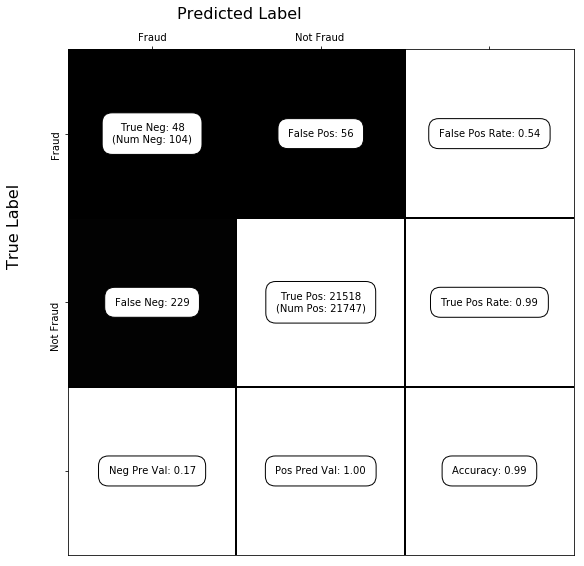

In [262]:
cm = confusion_matrix(y_test,model_gb.predict(X_test) , labels = [1,0])
show_confusion_matrix(cm, ['Fraud', 'Not Fraud '])

In [48]:
mf = modeldat.copy(deep = True)

In [50]:
cm = confusion_matrix(mf.iloc[:,-1],model_gb.predict(mf.iloc[:,:-1]) , labels = [1,0])
show_confusion_matrix(cm, ['Fraud', 'Not Fraud '])

ValueError: could not convert string to float: 'NY'

## What apps did we catch?

In [51]:
mf = modeldat.copy(deep=True)
mf['name']

0                   cavaliere
1                   cavaliere
2                   cavaliere
3                   cavaliere
4                   cavaliere
5                   cavaliere
6                   cavaliere
7                  winchester
8                fishersville
9                  midlothian
10           gvillemattoutlet
11               abfnashville
12                newportnews
13         rockhillmattoutlet
14         florencemattoutlet
15                  cavaliere
16                abfsavannah
17                  cavaliere
18               abfnashville
19            abffayetteville
20             christiansburg
21             christiansburg
22                  abfmyrtle
23                 abfraleigh
24                  cavaliere
25                      salem
26            abffayetteville
27                  cavaliere
28            abffayetteville
29       huntingtonmattoutlet
                 ...         
54030             furnfactory
54031             qualityfurn
54032     

In [52]:
modeldat_final.columns

Index(['direct_deposit', 'pp', 'homeowner_1', 'homeowner_2', 'homeowner_3',
       'payment_frequency_1', 'payment_frequency_2', 'payment_frequency_3',
       'payment_frequency_4', 'idv_A1', 'idv_A2', 'idv_D1', 'idv_D10',
       'idv_D2', 'idv_D3', 'idv_D4', 'idv_D5', 'idv_D6', 'idv_D7', 'idv_D8',
       'idv_D9', 'bav_A1', 'bav_A2', 'bav_A3', 'bav_D1', 'bav_D2', 'bav_D3',
       'appbin_1', 'appbin_2', 'appbin_3', 'appbin_4', 'leaseamount_x',
       'monthlyincome', 'datax', 'clarity', 'fico', 'clearfraud',
       'approved_amount', 'cumulative_utilization', 'apputil', 'dtf', 'cumdtf',
       'avgdtf', 'ssns_w_bank', 'add_num_bank', 'fraud1'],
      dtype='object')

In [53]:
mf['prob'] = model_gb.predict_proba(modeldat_final.iloc[:,:-1])[:,1]
mf['pred_fraud'] = model_gb.predict(modeldat_final.iloc[:,:-1])

In [54]:
first_fraud = mf.loc[mf['pred_fraud']==1].sort_values('numapps',ascending=True).reset_index(drop=True).groupby('name').first().reset_index(drop=False)

In [55]:
mf['first_fraud'] = mf.loc[mf['pred_fraud']==1].sort_values('numapps',ascending=True).reset_index(drop=True).groupby('name').transform('first')

ValueError: Wrong number of items passed 42, placement implies 1

In [56]:
first_fraud.loc[:, ['name', 'appnumber', 'appdate', 'prob', ]]

name appnumber    appdate  \
0                                   21stcenturyfurn   38481-1 2017-05-08   
1                                       abfsavannah   63046-1 2017-08-05   
2                                    adamsfurniture   33594-1 2017-04-11   
3                                    ajsrugsandfurn   33810-1 2017-04-12   
4                                 americanfurniture   25437-1 2017-02-27   
5                                     americantrade    2213-1 2015-08-28   
6                                        betterhome   20676-1 2017-01-23   
7                                         buybetter   33748-1 2017-04-12   
8   california furniture warehouse clearance center   63453-2 2017-10-26   
9                                  chitownfurnlinen   33434-1 2017-04-10   
10    classique furniture, appliances & electronics   67905-1 2017-09-07   
11                                            costa     820-1 2015-05-17   
12                                        crownfurn   41288-1 2017-05-22   
13                                          dcibeds   26466-2 2017-03-03   
14                                diamondloungefurn   41625-1 2017-05-24   
15                                discountfurniture   34316-1 2017-04-15   
16                                    discountmandm   35423-1 2017-04-22   
17                                     eastmainfurn   31115-1 2017-03-29   
18                                      elecforless   42399-1 2017-05-29   
19                                  exoticfurniture   21345-1 2017-01-29   
20                                 expressfurniture   27706-1 2017-03-09   
21                    factory direct mattress 4 you   86643-1 2017-12-16   
22                                        furndepot   39473-1 2017-05-12   
23                                   furnituredeals   30188-1 2017-03-24   
24                                   furniturelinen   29377-1 2017-03-19   
25                                       globalcomp   29114-1 2017-03-18   
26                                       goldenmatt   33766-1 2017-04-12   
27                    gulf coast mattress warehouse   62731-1 2017-08-03   
28                                    homefurniture   22495-1 2017-02-08   
29                                        homelinen   23963-1 2017-02-19   
30               johnny's crazy deals - panama city   78767-1 2017-11-09   
31                                        ladomfurn   23239-1 2017-02-14   
32                           liberty furniture llc.   71239-1 2017-09-29   
33                                      lincolnfurn   41001-1 2017-05-20   
34           m&a hotel furniture liquidation outlet   93346-1 2018-01-18   
35                                mattressandmorega   12692-1 2016-09-21   
36                                   mattressbyappt   10687-1 2016-07-28   
37                                    mattressfolks   17149-1 2016-12-01   
38                                       mbagardner   38131-1 2017-05-06   
39                                         mbatriad   13794-1 2016-10-12   
40                                    mbawakeforest   11406-1 2016-08-19   
41                                           mzfurn   32350-1 2017-04-04   
42                                        otromundo   29087-1 2017-03-17   
43                                      overstockmb   22850-1 2017-02-11   
44                                      paylessfurn   35413-1 2017-04-22   
45                                    queencityfurn   33562-1 2017-04-11   
46                                        reynafurn   44124-1 2017-06-07   
47                                        riccifurn   39372-1 2017-05-12   
48                                      sleepnation   84314-1 2017-12-04   
49                                        stateline   31238-1 2017-03-30   
50                                the furniture den   69857-1 2017-09-20   
51                                   todayfurniture   22733-1 2017-02-10   
52                 

In [57]:
mf[mf['name'].str.contains('gulf coast')]['cumulative_utilization']

4353    0.979980
4570    0.988560
4581    0.986653
4661    0.982264
4684    0.973955
Name: cumulative_utilization, dtype: float64

In [59]:
first_fraud['cumulative_utilization'].mean()

0.949483696517564

38
42
41
31
36


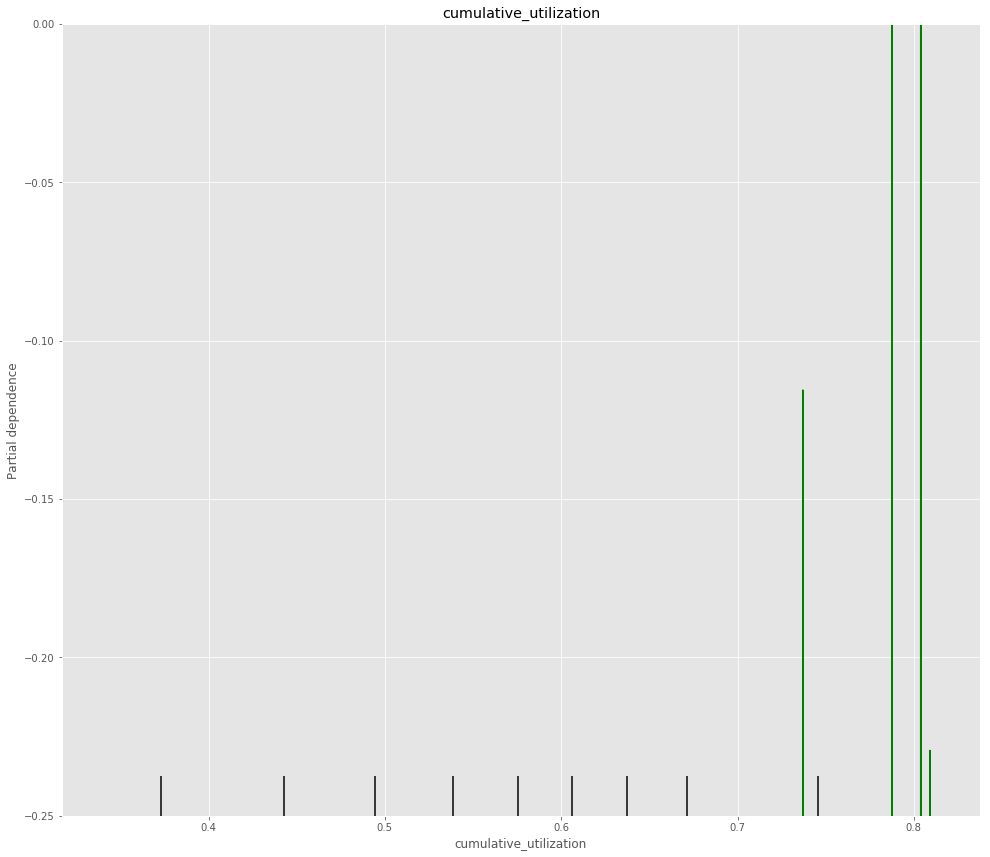

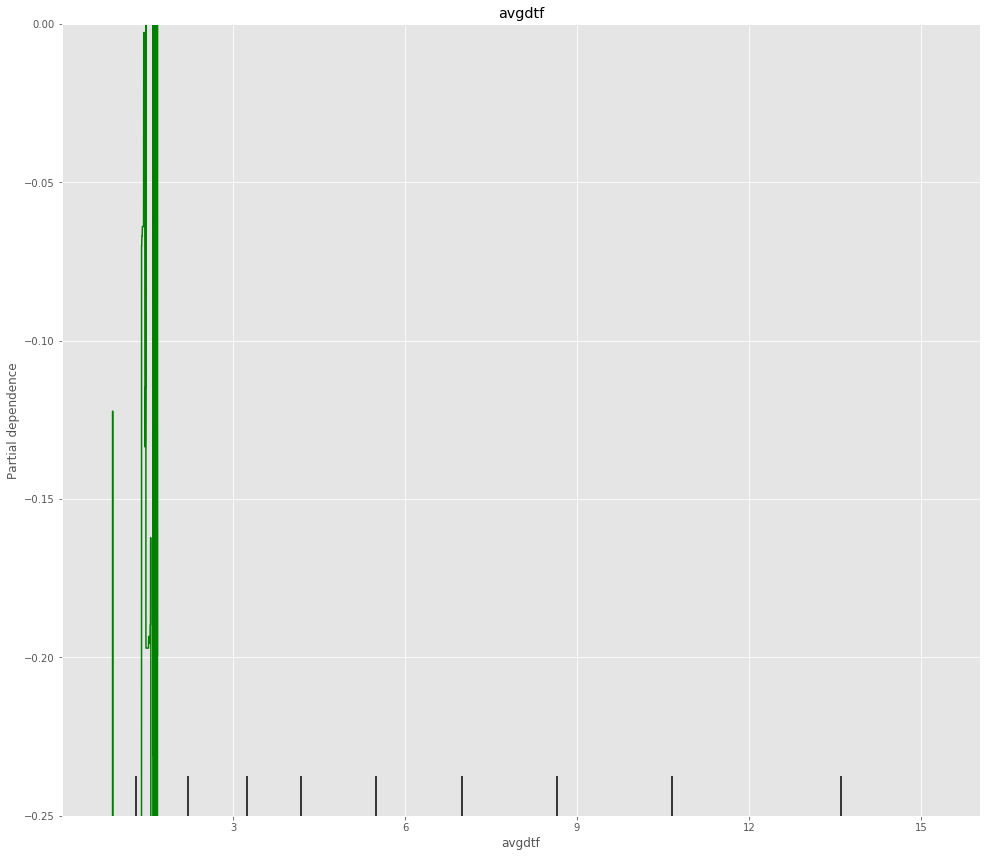

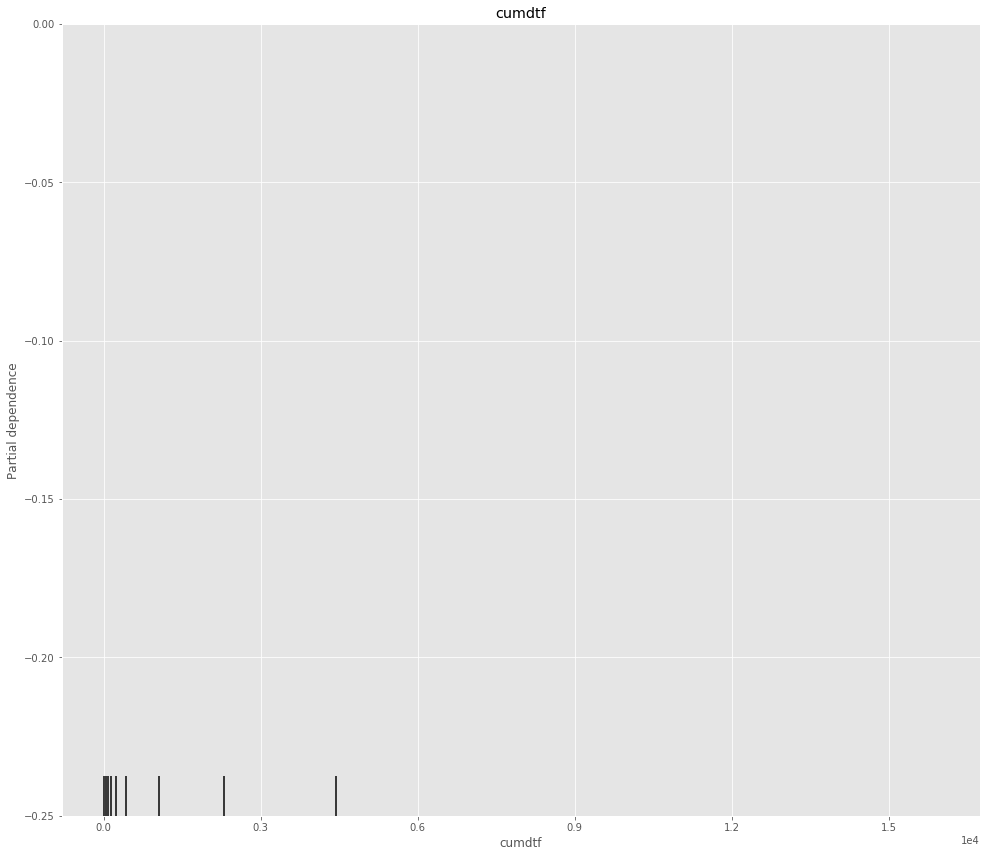

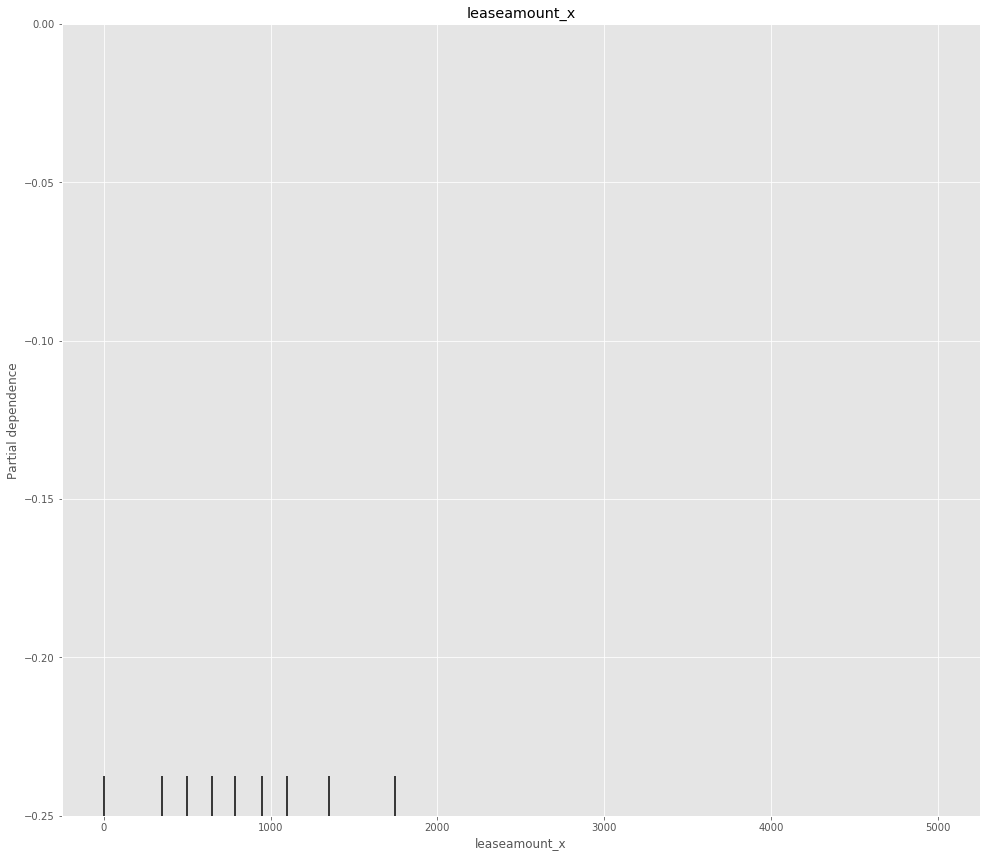

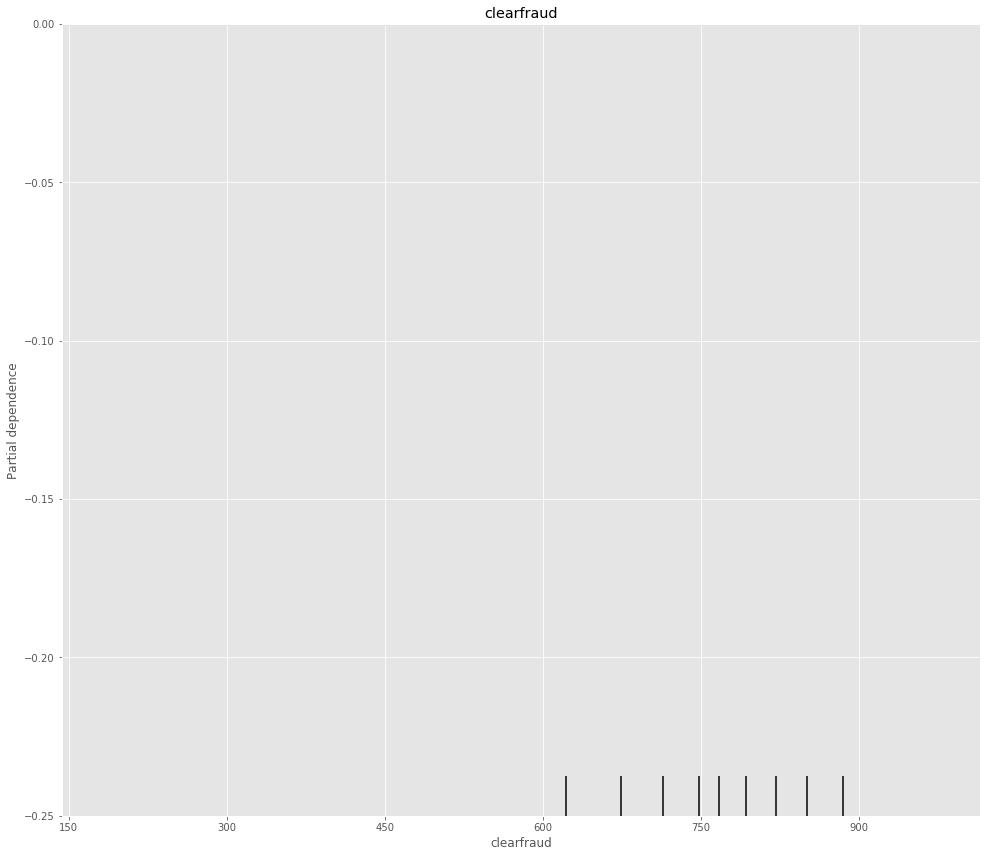

In [60]:
from matplotlib.backends.backend_pdf import PdfPages
cols = X_train.columns
matplotlib.style.use('ggplot')
pp = PdfPages('pdps3.pdf')
num_vars = 5
pd_plots = col_indices[0:num_vars]
for p in pd_plots: 
    figsize(15,20)
    features = [p]
    print(p)
    fig, axs = plot_partial_dependence(model_gb, X_train, features, 
                                       feature_names=cols, n_jobs=1, grid_resolution=10000)
    plt.title(cols[p])
    plt.ylim(-0.25,0)
    pp.savefig(fig)
pp.close()

# Deprecated

In [448]:
# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

# Fit the classifier to the training set
xg_cl.fit(X_train_res, y_train_res)

# Predict the labels of the test set: preds
preds = xg_cl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556'] ['cumulative_utilization', 'ssns_w_bank', 'monthly_income', 'add_num_bank', 'numapps', 'approved_amount', 'datax', 'clarity_comb', 'factor_trust', 'fico', 'clear_fraud', 'homeowner_ ', 'homeowner_F', 'homeowner_O', 'homeowner_R', 'homeowner_T', 'payment_frequency_BI-WEEKLY', 'payment_frequency_MONTHLY', 'payment_frequency_SEMI-MONTHLY', 'payment_frequency_UNKNOWN', 'payment_frequency_WEEKLY', 'idv_0', 'idv_A1', 'idv_A2', 'idv_D1', 'idv_D10', 'idv_D2', 'idv_D3', 'idv_D4', 'idv_D5', 'idv_D6', 'idv_D7', 'idv_D8', 'idv_D9', 'bav_0', 'bav_A1', 'bav_A2', 'bav_A3', 'bav_D1', 'bav_D2', 'bav_D3', 'zipzone_0.', 'zipzone_10', 'zipzone_11', 'zipzone_12', 'zipzone_13', 'zipzone_14', 'zipzone_15', 'zipzone_16', 'zipzone_17', 'zipzone_18', 'zipzone_19', 'zipzone_20', 'zipzone_21', 'zipzone_22', 'zipzone_23', 'zipzone_24', 'zipzone_25', 'zipzone_26', 'zipzone_27', 'zipzone_28', 'zipzone_29', 'zipzone_30', 'zipzone_31', 'zipzone_32', 'zipzone_33', 'zipzone_34', 'zipzone_35', 'zipzone_36', 'zipzone_37', 'zipzone_38', 'zipzone_39', 'zipzone_40', 'zipzone_41', 'zipzone_42', 'zipzone_43', 'zipzone_44', 'zipzone_45', 'zipzone_46', 'zipzone_47', 'zipzone_48', 'zipzone_49', 'zipzone_50', 'zipzone_51', 'zipzone_52', 'zipzone_53', 'zipzone_54', 'zipzone_55', 'zipzone_56', 'zipzone_57', 'zipzone_58', 'zipzone_59', 'zipzone_60', 'zipzone_61', 'zipzone_62', 'zipzone_63', 'zipzone_64', 'zipzone_65', 'zipzone_66', 'zipzone_67', 'zipzone_68', 'zipzone_70', 'zipzone_71', 'zipzone_72', 'zipzone_73', 'zipzone_74', 'zipzone_75', 'zipzone_76', 'zipzone_77', 'zipzone_78', 'zipzone_79', 'zipzone_80', 'zipzone_81', 'zipzone_82', 'zipzone_83', 'zipzone_84', 'zipzone_85', 'zipzone_86', 'zipzone_87', 'zipzone_88', 'zipzone_89', 'zipzone_90', 'zipzone_91', 'zipzone_92', 'zipzone_93', 'zipzone_94', 'zipzone_95', 'zipzone_96', 'zipzone_97', 'zipzone_98', 'zipzone_99', 'bin_      ', 'bin_0', 'bin_111111', 'bin_111122', 'bin_400022', 'bin_400023', 'bin_400029', 'bin_400046', 'bin_400114', 'bin_400123', 'bin_400177', 'bin_400218', 'bin_400259', 'bin_400298', 'bin_400521', 'bin_400570', 'bin_400760', 'bin_400796', 'bin_400803', 'bin_400821', 'bin_400981', 'bin_400982', 'bin_401105', 'bin_401128', 'bin_401139', 'bin_401142', 'bin_401150', 'bin_401154', 'bin_401160', 'bin_401164', 'bin_401171', 'bin_401174', 'bin_401195', 'bin_401197', 'bin_401301', 'bin_401331', 'bin_401333', 'bin_401356', 'bin_401524', 'bin_401534', 'bin_401535', 'bin_401538', 'bin_401539', 'bin_401644', 'bin_401659', 'bin_401670', 'bin_401672', 'bin_401777', 'bin_401807', 'bin_401826', 'bin_401842', 'bin_401864', 'bin_401865', 'bin_401897', 'bin_401982', 'bin_402011', 'bin_402018', 'bin_402020', 'bin_402031', 'bin_402047', 'bin_402049', 'bin_402050', 'bin_402066', 'bin_402070', 'bin_402073', 'bin_402079', 'bin_402089', 'bin_402109', 'bin_402140', 'bin_402144', 'bin_402164', 'bin_402165', 'bin_402190', 'bin_402201', 'bin_402202', 'bin_402203', 'bin_402214', 'bin_402267', 'bin_402282', 'bin_402291', 'bin_402347', 'bin_402461', 'bin_402464', 'bin_402642', 'bin_402675', 'bin_402762', 'bin_402944', 'bin_402950', 'bin_403101', 'bin_403103', 'bin_403120', 'bin_403124', 'bin_403133', 'bin_403216', 'bin_403239', 'bin_403240', 'bin_403241', 'bin_403286', 'bin_403470', 'bin_403487', 'bin_403490', 'bin_403493', 'bin_403494', 'bin_403495', 'bin_403532', 'bin_403578', 'bin_403590', 'bin_403613', 'bin_403623', 'bin_403638', 'bin_403704', 'bin_403710', 'bin_403786', 'bin_403905', 'bin_403924', 'bin_403926', 'bin_403995', 'bin_404153', 'bin_404206', 'bin_404220', 'bin_404225', 'bin_404253', 'bin_404388', 'bin_404389', 'bin_404513', 'bin_404551', 'bin_404561', 'bin_404562', 'bin_404570', 'bin_404594', 'bin_404621', 'bin_404628', 'bin_404654', 'bin_404657', 'bin_404682', 'bin_404795', 'bin_404957', 'bin_404964', 'bin_405032', 'bin_405076', 'bin_405228', 'bin_405376', 'bin_405385', 'bin_405418', 'bin_405425', 'bin_405428', 'bin_405447', 'bin_405466', 'bin_405537', 'bin_405560', 'bin_405581', 'bin_405605', 'bin_405610', 'bin_405627', 'bin_405738', 'bin_405748', 'bin_405818', 'bin_405828', 'bin_406003', 'bin_406019', 'bin_406021', 'bin_406032', 'bin_406042', 'bin_406049', 'bin_406068', 'bin_406095', 'bin_406317', 'bin_406406', 'bin_406498', 'bin_406632', 'bin_406635', 'bin_407020', 'bin_407032', 'bin_407065', 'bin_407135', 'bin_407141', 'bin_407204', 'bin_407227', 'bin_407238', 'bin_407253', 'bin_407272', 'bin_407336', 'bin_407444', 'bin_407624', 'bin_407746', 'bin_407773', 'bin_407941', 'bin_407945', 'bin_408031', 'bin_408096', 'bin_408121', 'bin_408137', 'bin_408185', 'bin_408191', 'bin_408501', 'bin_408530', 'bin_408540', 'bin_408588', 'bin_408677', 'bin_408681', 'bin_408689', 'bin_408691', 'bin_408872', 'bin_408880', 'bin_408881', 'bin_409119', 'bin_409249', 'bin_409259', 'bin_409290', 'bin_409297', 'bin_409311', 'bin_409312', 'bin_409434', 'bin_409589', 'bin_409609', 'bin_409974', 'bin_410070', 'bin_410106', 'bin_410113', 'bin_410118', 'bin_410489', 'bin_410702', 'bin_410707', 'bin_410836', 'bin_410839', 'bin_410843', 'bin_410844', 'bin_410846', 'bin_410870', 'bin_410872', 'bin_410894', 'bin_410955', 'bin_411047', 'bin_411079', 'bin_411207', 'bin_411250', 'bin_411326', 'bin_411328', 'bin_411346', 'bin_411348', 'bin_411399', 'bin_411457', 'bin_411547', 'bin_411573', 'bin_411591', 'bin_411616', 'bin_411618', 'bin_411619', 'bin_411770', 'bin_411771', 'bin_411773', 'bin_411774', 'bin_411776', 'bin_411777', 'bin_411806', 'bin_411877', 'bin_411918', 'bin_412006', 'bin_412007', 'bin_412092', 'bin_412094', 'bin_412116', 'bin_412141', 'bin_412270', 'bin_412278', 'bin_412451', 'bin_412493', 'bin_412627', 'bin_412637', 'bin_412712', 'bin_412757', 'bin_412758', 'bin_412938', 'bin_413013', 'bin_413022', 'bin_413138', 'bin_413148', 'bin_413171', 'bin_413176', 'bin_413177', 'bin_413186', 'bin_413357', 'bin_413491', 'bin_413498', 'bin_413499', 'bin_413550', 'bin_413557', 'bin_413571', 'bin_413574', 'bin_413587', 'bin_413613', 'bin_413619', 'bin_413748', 'bin_413757', 'bin_413790', 'bin_413802', 'bin_413817', 'bin_413821', 'bin_413826', 'bin_413910', 'bin_413916', 'bin_413920', 'bin_413923', 'bin_413935', 'bin_413946', 'bin_413948', 'bin_413950', 'bin_413957', 'bin_413978', 'bin_413979', 'bin_413987', 'bin_413999', 'bin_414034', 'bin_414133', 'bin_414221', 'bin_414242', 'bin_414270', 'bin_414314', 'bin_414315', 'bin_414397', 'bin_414398', 'bin_414403', 'bin_414407', 'bin_414446', 'bin_414510', 'bin_414517', 'bin_414518', 'bin_414616', 'bin_414720', 'bin_414956', 'bin_414988', 'bin_415082', 'bin_415091', 'bin_415115', 'bin_415145', 'bin_415146', 'bin_415179', 'bin_415235', 'bin_415296', 'bin_415307', 'bin_415336', 'bin_415384', 'bin_415490', 'bin_415538', 'bin_415539', 'bin_415546', 'bin_415578', 'bin_415579', 'bin_415588', 'bin_415593', 'bin_415609', 'bin_415618', 'bin_415624', 'bin_415710', 'bin_415711', 'bin_415715', 'bin_415726', 'bin_415729', 'bin_415746', 'bin_415758', 'bin_415769', 'bin_415775', 'bin_415783', 'bin_415793', 'bin_415819', 'bin_415823', 'bin_415825', 'bin_415826', 'bin_415860', 'bin_415863', 'bin_415869', 'bin_415881', 'bin_415913', 'bin_415926', 'bin_415967', 'bin_415973', 'bin_415975', 'bin_415976', 'bin_415977', 'bin_415978', 'bin_415982', 'bin_415993', 'bin_416003', 'bin_416046', 'bin_416169', 'bin_416185', 'bin_416462', 'bin_416616', 'bin_416626', 'bin_416785', 'bin_416844', 'bin_416860', 'bin_416869', 'bin_416992', 'bin_416993', 'bin_416994', 'bin_416995', 'bin_417021', 'bin_417700', 'bin_417701', 'bin_417907', 'bin_418021', 'bin_418033', 'bin_418097', 'bin_418221', 'bin_418505', 'bin_418517', 'bin_418524', 'bin_418546', 'bin_418642', 'bin_418646', 'bin_419002', 'bin_419011', 'bin_419028', 'bin_419032', 'bin_419047', 'bin_419090', 'bin_419162', 'bin_419423', 'bin_419473', 'bin_419485', 'bin_419493', 'bin_419494', 'bin_419498', 'bin_420026', 'bin_420027', 'bin_420051', 'bin_420064', 'bin_420071', 'bin_420073', 'bin_420300', 'bin_420413', 'bin_420436', 'bin_420497', 'bin_420687', 'bin_420700', 'bin_420737', 'bin_420767', 'bin_420919', 'bin_420955', 'bin_421015', 'bin_421043', 'bin_421065', 'bin_421075', 'bin_421077', 'bin_421091', 'bin_421092', 'bin_421701', 'bin_421778', 'bin_422323', 'bin_422359', 'bin_422432', 'bin_422461', 'bin_422470', 'bin_422473', 'bin_422481', 'bin_422496', 'bin_422499', 'bin_422572', 'bin_422676', 'bin_422707', 'bin_422710', 'bin_422741', 'bin_422747', 'bin_422768', 'bin_422772', 'bin_422852', 'bin_422855', 'bin_422866', 'bin_422912', 'bin_422919', 'bin_422921', 'bin_422956', 'bin_422968', 'bin_423223', 'bin_423588', 'bin_423673', 'bin_423810', 'bin_423816', 'bin_423817', 'bin_423818', 'bin_423827', 'bin_423828', 'bin_423829', 'bin_423831', 'bin_423848', 'bin_423855', 'bin_423857', 'bin_423870', 'bin_423878', 'bin_423882', 'bin_423885', 'bin_423902', 'bin_423909', 'bin_423910', 'bin_423924', 'bin_424002', 'bin_424009', 'bin_424018', 'bin_424030', 'bin_424142', 'bin_424245', 'bin_424660', 'bin_424721', 'bin_424744', 'bin_424748', 'bin_424790', 'bin_424796', 'bin_425031', 'bin_425032', 'bin_425054', 'bin_425072', 'bin_425131', 'bin_425141', 'bin_425142', 'bin_425152', 'bin_425356', 'bin_425407', 'bin_425421', 'bin_425473', 'bin_425488', 'bin_425627', 'bin_425628', 'bin_425637', 'bin_425808', 'bin_425809', 'bin_425816', 'bin_425826', 'bin_425828', 'bin_425829', 'bin_425830', 'bin_425836', 'bin_425838', 'bin_425907', 'bin_425908', 'bin_425909', 'bin_425922', 'bin_425954', 'bin_426207', 'bin_426403', 'bin_426406', 'bin_426408', 'bin_426456', 'bin_426617', 'bin_426628', 'bin_426629', 'bin_426631', 'bin_426670', 'bin_426752', 'bin_426754', 'bin_426764', 'bin_426767', 'bin_426787', 'bin_426937', 'bin_426964', 'bin_426967', 'bin_427040', 'bin_427060', 'bin_427082', 'bin_427088', 'bin_427096', 'bin_427099', 'bin_427122', 'bin_427144', 'bin_427146', 'bin_427178', 'bin_427195', 'bin_427199', 'bin_427488', 'bin_427489', 'bin_427514', 'bin_427538', 'bin_427544', 'bin_427569', 'bin_428003', 'bin_428190', 'bin_428208', 'bin_428702', 'bin_429117', 'bin_429123', 'bin_429134', 'bin_429136', 'bin_429154', 'bin_429177', 'bin_429232', 'bin_429263', 'bin_429294', 'bin_429400', 'bin_429413', 'bin_429416', 'bin_429420', 'bin_429442', 'bin_429444', 'bin_429458', 'bin_429475', 'bin_429476', 'bin_429488', 'bin_429633', 'bin_429672', 'bin_429819', 'bin_429820', 'bin_429839', 'bin_429977', 'bin_430070', 'bin_430083', 'bin_430234', 'bin_430403', 'bin_430508', 'bin_430558', 'bin_430560', 'bin_430569', 'bin_430586', 'bin_430594', 'bin_430602', 'bin_430604', 'bin_430605', 'bin_430612', 'bin_430613', 'bin_430627', 'bin_430629', 'bin_430631', 'bin_430644', 'bin_430678', 'bin_430682', 'bin_430731', 'bin_430746', 'bin_430758', 'bin_430791', 'bin_430810', 'bin_430854', 'bin_430858', 'bin_430885', 'bin_430914', 'bin_430941', 'bin_430947', 'bin_431406', 'bin_431432', 'bin_431452', 'bin_431470', 'bin_431471', 'bin_431579', 'bin_431615', 'bin_431628', 'bin_431678', 'bin_431719', 'bin_432548', 'bin_432623', 'bin_432626', 'bin_432628', 'bin_432630', 'bin_432642', 'bin_432650', 'bin_432653', 'bin_432666', 'bin_432672', 'bin_432694', 'bin_432739', 'bin_432825', 'bin_432855', 'bin_432861', 'bin_432862', 'bin_432863', 'bin_432881', 'bin_432964', 'bin_433032', 'bin_433062', 'bin_433177', 'bin_433252', 'bin_433256', 'bin_433443', 'bin_433477', 'bin_433557', 'bin_433686', 'bin_433716', 'bin_433718', 'bin_433719', 'bin_433757', 'bin_433765', 'bin_433775', 'bin_433852', 'bin_433857', 'bin_433994', 'bin_434167', 'bin_434217', 'bin_434249', 'bin_434254', 'bin_434256', 'bin_434257', 'bin_434258', 'bin_434260', 'bin_434769', 'bin_435127', 'bin_435140', 'bin_435142', 'bin_435155', 'bin_435173', 'bin_435179', 'bin_435272', 'bin_435285', 'bin_435314', 'bin_435387', 'bin_435541', 'bin_435544', 'bin_435545', 'bin_435546', 'bin_435547', 'bin_435587', 'bin_435603', 'bin_435619', 'bin_435630', 'bin_435640', 'bin_435643', 'bin_435662', 'bin_435671', 'bin_435683', 'bin_435684', 'bin_435685', 'bin_435687', 'bin_435702', 'bin_435716', 'bin_435727', 'bin_435758', 'bin_435760', 'bin_435791', 'bin_435792', 'bin_435812', 'bin_435836', 'bin_435837', 'bin_435857', 'bin_435888', 'bin_435893', 'bin_435912', 'bin_435926', 'bin_435954', 'bin_435970', 'bin_435976', 'bin_436165', 'bin_436169', 'bin_436173', 'bin_436177', 'bin_436182', 'bin_436618', 'bin_436649', 'bin_436668', 'bin_436698', 'bin_436706', 'bin_436713', 'bin_436802', 'bin_436879', 'bin_436898', 'bin_437302', 'bin_437303', 'bin_437304', 'bin_437306', 'bin_437307', 'bin_437309', 'bin_437331', 'bin_437780', 'bin_437795', 'bin_437821', 'bin_437823', 'bin_438117', 'bin_438170', 'bin_438194', 'bin_438291', 'bin_438293', 'bin_438419', 'bin_438464', 'bin_438467', 'bin_438482', 'bin_438489', 'bin_438567', 'bin_438569', 'bin_438634', 'bin_438701', 'bin_438787', 'bin_438811', 'bin_438820', 'bin_438915', 'bin_438951', 'bin_438954', 'bin_439331', 'bin_439395', 'bin_439397', 'bin_439460', 'bin_439461', 'bin_439464', 'bin_439875', 'bin_439878', 'bin_439885', 'bin_439911', 'bin_439977', 'bin_440066', 'bin_440094', 'bin_440150', 'bin_440213', 'bin_440215', 'bin_440336', 'bin_440354', 'bin_440358', 'bin_440383', 'bin_440387', 'bin_440393', 'bin_440410', 'bin_440486', 'bin_440487', 'bin_440830', 'bin_440843', 'bin_440881', 'bin_440911', 'bin_440952', 'bin_440977', 'bin_441103', 'bin_441104', 'bin_441105', 'bin_441240', 'bin_441243', 'bin_441251', 'bin_441268', 'bin_441276', 'bin_441281', 'bin_441282', 'bin_441413', 'bin_441420', 'bin_441443', 'bin_441480', 'bin_441494', 'bin_441691', 'bin_441709', 'bin_441731', 'bin_441767', 'bin_441814', 'bin_441858', 'bin_441892', 'bin_441896', 'bin_441938', 'bin_441946', 'bin_441975', 'bin_441977', 'bin_442043', 'bin_442062', 'bin_442084', 'bin_442223', 'bin_442319', 'bin_442326', 'bin_442346', 'bin_442377', 'bin_442391', 'bin_442487', 'bin_442497', 'bin_442519', 'bin_442521', 'bin_442555', 'bin_442558', 'bin_442584', 'bin_442589', 'bin_442592', 'bin_442640', 'bin_442642', 'bin_442643', 'bin_442644', 'bin_442657', 'bin_442668', 'bin_442680', 'bin_442719', 'bin_442732', 'bin_442742', 'bin_442743', 'bin_442755', 'bin_442777', 'bin_442787', 'bin_442788', 'bin_442790', 'bin_442791', 'bin_442792', 'bin_442793', 'bin_442794', 'bin_442795', 'bin_442796', 'bin_442904', 'bin_442958', 'bin_442964', 'bin_442971', 'bin_443003', 'bin_443040', 'bin_443041', 'bin_443043', 'bin_443044', 'bin_443045', 'bin_443046', 'bin_443047', 'bin_443048', 'bin_443049', 'bin_443050', 'bin_443051', 'bin_443057', 'bin_443060', 'bin_443067', 'bin_443113', 'bin_443178', 'bin_443238', 'bin_443242', 'bin_443264', 'bin_443276', 'bin_443512', 'bin_443516', 'bin_443532', 'bin_443547', 'bin_443581', 'bin_443586', 'bin_443589', 'bin_443597', 'bin_443628', 'bin_443646', 'bin_443659', 'bin_443666', 'bin_443683', 'bin_443686', 'bin_443900', 'bin_443903', 'bin_444083', 'bin_444206', 'bin_444253', 'bin_444258', 'bin_444394', 'bin_444405', 'bin_444409', 'bin_444423', 'bin_444427', 'bin_444487', 'bin_444724', 'bin_444796', 'bin_444968', 'bin_445100', 'bin_445101', 'bin_445102', 'bin_445170', 'bin_445171', 'bin_445178', 'bin_445206', 'bin_445216', 'bin_445250', 'bin_445311', 'bin_445320', 'bin_445321', 'bin_445400', 'bin_445423', 'bin_445649', 'bin_445785', 'bin_445990', 'bin_445999', 'bin_446053', 'bin_446487', 'bin_446525', 'bin_446531', 'bin_446542', 'bin_446550', 'bin_446552', 'bin_446744', 'bin_446749', 'bin_446758', 'bin_446777', 'bin_446831', 'bin_446857', 'bin_447047', 'bin_447083', 'bin_447098', 'bin_447216', 'bin_447305', 'bin_447308', 'bin_447433', 'bin_447437', 'bin_447438', 'bin_447452', 'bin_447459', 'bin_447463', 'bin_447482', 'bin_447483', 'bin_447626', 'bin_447707', 'bin_447710', 'bin_447713', 'bin_447734', 'bin_447745', 'bin_447754', 'bin_447766', 'bin_447802', 'bin_447913', 'bin_447933', 'bin_447952', 'bin_447954', 'bin_447971', 'bin_447972', 'bin_447973', 'bin_447976', 'bin_447979', 'bin_448005', 'bin_448034', 'bin_448049', 'bin_448101', 'bin_448135', 'bin_448169', 'bin_448209', 'bin_448210', 'bin_448224', 'bin_448231', 'bin_448232', 'bin_448233', 'bin_448239', 'bin_448241', 'bin_448251', 'bin_448261', 'bin_448263', 'bin_448270', 'bin_448275', 'bin_448288', 'bin_448297', 'bin_448380', 'bin_448774', 'bin_448775', 'bin_448815', 'bin_448819', 'bin_448820', 'bin_448825', 'bin_448844', 'bin_448849', 'bin_448857', 'bin_448859', 'bin_449052', 'bin_449070', 'bin_449071', 'bin_449083', 'bin_449117', 'bin_449125', 'bin_449139', 'bin_449144', 'bin_449145', 'bin_449163', 'bin_449210', 'bin_449219', 'bin_449221', 'bin_449239', 'bin_449247', 'bin_449264', 'bin_449278', 'bin_449308', 'bin_449351', 'bin_449370', 'bin_449373', 'bin_449406', 'bin_449435', 'bin_449449', 'bin_449470', 'bin_449477', 'bin_449501', 'bin_449507', 'bin_449510', 'bin_449511', 'bin_449512', 'bin_449517', 'bin_449551', 'bin_449553', 'bin_449561', 'bin_449590', 'bin_449591', 'bin_449594', 'bin_449597', 'bin_449602', 'bin_449604', 'bin_449608', 'bin_449610', 'bin_449611', 'bin_449613', 'bin_449614', 'bin_449616', 'bin_449619', 'bin_449631', 'bin_449633', 'bin_449640', 'bin_449652', 'bin_449653', 'bin_449662', 'bin_449664', 'bin_449665', 'bin_449719', 'bin_449733', 'bin_449809', 'bin_449814', 'bin_449839', 'bin_449906', 'bin_449996', 'bin_450241', 'bin_450242', 'bin_450247', 'bin_450270', 'bin_450277', 'bin_450381', 'bin_450399', 'bin_450455', 'bin_450467', 'bin_450468', 'bin_450644', 'bin_451056', 'bin_451062', 'bin_451175', 'bin_451228', 'bin_451431', 'bin_451440', 'bin_451666', 'bin_451676', 'bin_451720', 'bin_451805', 'bin_452262', 'bin_452277', 'bin_452399', 'bin_452912', 'bin_453271', 'bin_453506', 'bin_453531', 'bin_453572', 'bin_453575', 'bin_453584', 'bin_453598', 'bin_453840', 'bin_454506', 'bin_454507', 'bin_454951', 'bin_454969', 'bin_455225', 'bin_455458', 'bin_455568', 'bin_455569', 'bin_455917', 'bin_455977', 'bin_456323', 'bin_456331', 'bin_456367', 'bin_456534', 'bin_456625', 'bin_456628', 'bin_457085', 'bin_457431', 'bin_458415', 'bin_458438', 'bin_458643', 'bin_459954', 'bin_460007', 'bin_460127', 'bin_460140', 'bin_460159', 'bin_460161', 'bin_460162', 'bin_460213', 'bin_460223', 'bin_460297', 'bin_460389', 'bin_460444', 'bin_460699', 'bin_460709', 'bin_460722', 'bin_460727', 'bin_460730', 'bin_460741', 'bin_460753', 'bin_460821', 'bin_460822', 'bin_460823', 'bin_460830', 'bin_460855', 'bin_460864', 'bin_460867', 'bin_460896', 'bin_460897', 'bin_461046', 'bin_461100', 'bin_461104', 'bin_461181', 'bin_461183', 'bin_461235', 'bin_461293', 'bin_461675', 'bin_462111', 'bin_462652', 'bin_462655', 'bin_463097', 'bin_463101', 'bin_463158', 'bin_463405', 'bin_463452', 'bin_463491', 'bin_463493', 'bin_463569', 'bin_463573', 'bin_463574', 'bin_463575', 'bin_463577', 'bin_463578', 'bin_463579', 'bin_463584', 'bin_463589', 'bin_463656', 'bin_463684', 'bin_463884', 'bin_464303', 'bin_464359', 'bin_464459', 'bin_464701', 'bin_464705', 'bin_464706', 'bin_464719', 'bin_464733', 'bin_464754', 'bin_464772', 'bin_464869', 'bin_464929', 'bin_465156', 'bin_465288', 'bin_465290', 'bin_465291', 'bin_465292', 'bin_465293', 'bin_465345', 'bin_465504', 'bin_465509', 'bin_465513', 'bin_465531', 'bin_465614', 'bin_465703', 'bin_466001', 'bin_466003', 'bin_466186', 'bin_466187', 'bin_466188', 'bin_466189', 'bin_466600', 'bin_466602', 'bin_466801', 'bin_466805', 'bin_467001', 'bin_467010', 'bin_467068', 'bin_467316', 'bin_467321', 'bin_467339', 'bin_467397', 'bin_467499', 'bin_467595', 'bin_467610', 'bin_468005', 'bin_468018', 'bin_468030', 'bin_468031', 'bin_468049', 'bin_468050', 'bin_468052', 'bin_468075', 'bin_468101', 'bin_468104', 'bin_468119', 'bin_468271', 'bin_468451', 'bin_468462', 'bin_468856', 'bin_468881', 'bin_469004', 'bin_469010', 'bin_469072', 'bin_469090', 'bin_469091', 'bin_469097', 'bin_469208', 'bin_469307', 'bin_469418', 'bin_469441', 'bin_469461', 'bin_469542', 'bin_469558', 'bin_470102', 'bin_470117', 'bin_470124', 'bin_470132', 'bin_470133', 'bin_470134', 'bin_470144', 'bin_470145', 'bin_470189', 'bin_470317', 'bin_470403', 'bin_470406', 'bin_470626', 'bin_470727', 'bin_470757', 'bin_470785', 'bin_471318', 'bin_471319', 'bin_471724', 'bin_471778', 'bin_471837', 'bin_471849', 'bin_471858', 'bin_471876', 'bin_471886', 'bin_471953', 'bin_472170', 'bin_472379', 'bin_472392', 'bin_472520', 'bin_472747', 'bin_472758', 'bin_472776', 'bin_472777', 'bin_472970', 'bin_472972', 'bin_472973', 'bin_473000', 'bin_473027', 'bin_473049', 'bin_473093', 'bin_473094', 'bin_473099', 'bin_473151', 'bin_473157', 'bin_473300', 'bin_473302', 'bin_473310', 'bin_473311', 'bin_473379', 'bin_473439', 'bin_473477', 'bin_473490', 'bin_473614', 'bin_473622', 'bin_473677', 'bin_473690', 'bin_473691', 'bin_473702', 'bin_473703', 'bin_473905', 'bin_473908', 'bin_473969', 'bin_473986', 'bin_473992', 'bin_474165', 'bin_474166', 'bin_474187', 'bin_474307', 'bin_474472', 'bin_474473', 'bin_474474', 'bin_474475', 'bin_474476', 'bin_474477', 'bin_474478', 'bin_474479', 'bin_474480', 'bin_474481', 'bin_474482', 'bin_474483', 'bin_474484', 'bin_474485', 'bin_474486', 'bin_474487', 'bin_474488', 'bin_474489', 'bin_474665', 'bin_474881', 'bin_474884', 'bin_474888', 'bin_474892', 'bin_474893', 'bin_474895', 'bin_474896', 'bin_474898', 'bin_475015', 'bin_475024', 'bin_475033', 'bin_475036', 'bin_475045', 'bin_475055', 'bin_475467', 'bin_475471', 'bin_475497', 'bin_475543', 'bin_475636', 'bin_475644', 'bin_475818', 'bin_475831', 'bin_475869', 'bin_476158', 'bin_476164', 'bin_476165', 'bin_476478', 'bin_476497', 'bin_476516', 'bin_476546', 'bin_476554', 'bin_476559', 'bin_476567', 'bin_476585', 'bin_476586', 'bin_476708', 'bin_476732', 'bin_476929', 'bin_476972', 'bin_476973', 'bin_476974', 'bin_476975', 'bin_477008', 'bin_477349', 'bin_477351', 'bin_477478', 'bin_477536', 'bin_477555', 'bin_477810', 'bin_477825', 'bin_477842', 'bin_477877', 'bin_477884', 'bin_477897', 'bin_478058', 'bin_478200', 'bin_478241', 'bin_478335', 'bin_478381', 'bin_478397', 'bin_478412', 'bin_478418', 'bin_478442', 'bin_478499', 'bin_478655', 'bin_478662', 'bin_478820', 'bin_478821', 'bin_478920', 'bin_478967', 'bin_478973', 'bin_478975', 'bin_478982', 'bin_479013', 'bin_479102', 'bin_479112', 'bin_479125', 'bin_479144', 'bin_479171', 'bin_479193', 'bin_479195', 'bin_479197', 'bin_479198', 'bin_479208', 'bin_479209', 'bin_479210', 'bin_479213', 'bin_479215', 'bin_479231', 'bin_479248', 'bin_479251', 'bin_479271', 'bin_479281', 'bin_479289', 'bin_479346', 'bin_479369', 'bin_479370', 'bin_479372', 'bin_479417', 'bin_479511', 'bin_479841', 'bin_479884', 'bin_480128', 'bin_480158', 'bin_480209', 'bin_480245', 'bin_480278', 'bin_480307', 'bin_480312', 'bin_480358', 'bin_480365', 'bin_480373', 'bin_480639', 'bin_480641', 'bin_480642', 'bin_480643', 'bin_480694', 'bin_480922', 'bin_481102', 'bin_481110', 'bin_481120', 'bin_481171', 'bin_481172', 'bin_481179', 'bin_481582', 'bin_481583', 'bin_481588', 'bin_481759', 'bin_481774', 'bin_481775', 'bin_481961', 'bin_482163', 'bin_482850', 'bin_482851', 'bin_482853', 'bin_482854', 'bin_482855', 'bin_482857', 'bin_482862', 'bin_482865', 'bin_482924', 'bin_483312', 'bin_483313', 'bin_483314', 'bin_483316', 'bin_483331', 'bin_483354', 'bin_483480', 'bin_483493', 'bin_483909', 'bin_484054', 'bin_484239', 'bin_484545', 'bin_484608', 'bin_484715', 'bin_484718', 'bin_485237', 'bin_485246', 'bin_485279', 'bin_485320', 'bin_485340', 'bin_485381', 'bin_485383', 'bin_485560', 'bin_485584', 'bin_485631', 'bin_485804', 'bin_486111', 'bin_486123', 'bin_486132', 'bin_486135', 'bin_486151', 'bin_486152', 'bin_486153', 'bin_486310', 'bin_486732', 'bin_486796', 'bin_486898', 'bin_486899', 'bin_486903', 'bin_486921', 'bin_486932', 'bin_486945', 'bin_486957', 'bin_486959', 'bin_486976', 'bin_486983', 'bin_487081', 'bin_487298', 'bin_487382', 'bin_487466', 'bin_487471', 'bin_488859', 'bin_489138', 'bin_489208', 'bin_489217', 'bin_489272', 'bin_489275', 'bin_489657', 'bin_489747', 'bin_489920', 'bin_490039', 'bin_490062', 'bin_490071', 'bin_490410', 'bin_490619', 'bin_490640', 'bin_490911', 'bin_490973', 'bin_491239', 'bin_491288', 'bin_491449', 'bin_491458', 'bin_491585', 'bin_491901', 'bin_491905', 'bin_491919', 'bin_491930', 'bin_492170', 'bin_493419', 'bin_494001', 'bin_494139', 'bin_494159', 'bin_494160', 'bin_494321', 'bin_494340', 'bin_494390', 'bin_497935', 'bin_498404', 'bin_498879', 'bin_499106', 'bin_499140', 'bin_499145', 'bin_499159', 'bin_499920', 'bin_499940', 'bin_508181', 'bin_510263', 'bin_510277', 'bin_510303', 'bin_510332', 'bin_510339', 'bin_510345', 'bin_510373', 'bin_510386', 'bin_510392', 'bin_510579', 'bin_510587', 'bin_510619', 'bin_510637', 'bin_510643', 'bin_510659', 'bin_510666', 'bin_510677', 'bin_510691', 'bin_510695', 'bin_510702', 'bin_510746', 'bin_510747', 'bin_510762', 'bin_510774', 'bin_510780', 'bin_510782', 'bin_510785', 'bin_510796', 'bin_510805', 'bin_510824', 'bin_510833', 'bin_510840', 'bin_510875', 'bin_510876', 'bin_510890', 'bin_510896', 'bin_510902', 'bin_510921', 'bin_510931', 'bin_510933', 'bin_510939', 'bin_510946', 'bin_510981', 'bin_510982', 'bin_511011', 'bin_511012', 'bin_511017', 'bin_511036', 'bin_511040', 'bin_511058', 'bin_511078', 'bin_511082', 'bin_511091', 'bin_511093', 'bin_511100', 'bin_511104', 'bin_511113', 'bin_511118', 'bin_511122', 'bin_511135', 'bin_511144', 'bin_511145', 'bin_511152', 'bin_511165', 'bin_511186', 'bin_511190', 'bin_511196', 'bin_511197', 'bin_511207', 'bin_511211', 'bin_511220', 'bin_511236', 'bin_511238', 'bin_511244', 'bin_511245', 'bin_511248', 'bin_511271', 'bin_511278', 'bin_511292', 'bin_511308', 'bin_511313', 'bin_511317', 'bin_511321', 'bin_511361', 'bin_511368', 'bin_511388', 'bin_511413', 'bin_511415', 'bin_511423', 'bin_511457', 'bin_511516', 'bin_511558', 'bin_511560', 'bin_511565', 'bin_511948', 'bin_511977', 'bin_512773', 'bin_512854', 'bin_512876', 'bin_512951', 'bin_512957', 'bin_512975', 'bin_512987', 'bin_512988', 'bin_512991', 'bin_512992', 'bin_512993', 'bin_513059', 'bin_513519', 'bin_513522', 'bin_513534', 'bin_513876', 'bin_513881', 'bin_514132', 'bin_514136', 'bin_514138', 'bin_514169', 'bin_514170', 'bin_514181', 'bin_514187', 'bin_514192', 'bin_514195', 'bin_514204', 'bin_514225', 'bin_514230', 'bin_514253', 'bin_514336', 'bin_514383', 'bin_514385', 'bin_514400', 'bin_514401', 'bin_514402', 'bin_514441', 'bin_514452', 'bin_514458', 'bin_514460', 'bin_514476', 'bin_514483', 'bin_514491', 'bin_514518', 'bin_514535', 'bin_514546', 'bin_514554', 'bin_514555', 'bin_514573', 'bin_514574', 'bin_514609', 'bin_514616', 'bin_514621', 'bin_514622', 'bin_514636', 'bin_514750', 'bin_514751', 'bin_514753', 'bin_514759', 'bin_514776', 'bin_514782', 'bin_514783', 'bin_514798', 'bin_514800', 'bin_514807', 'bin_514810', 'bin_514816', 'bin_514821', 'bin_514827', 'bin_514887', 'bin_514963', 'bin_514966', 'bin_514968', 'bin_514969', 'bin_514978', 'bin_514979', 'bin_514993', 'bin_514997', 'bin_515021', 'bin_515034', 'bin_515069', 'bin_515080', 'bin_515090', 'bin_515091', 'bin_515101', 'bin_515140', 'bin_515158', 'bin_515170', 'bin_515180', 'bin_515186', 'bin_515206', 'bin_515223', 'bin_515237', 'bin_515240', 'bin_515241', 'bin_515248', 'bin_515252', 'bin_515255', 'bin_515274', 'bin_515281', 'bin_515282', 'bin_515325', 'bin_515327', 'bin_515345', 'bin_515355', 'bin_515477', 'bin_515549', 'bin_515550', 'bin_515597', 'bin_515915', 'bin_515936', 'bin_515940', 'bin_515948', 'bin_515978', 'bin_515990', 'bin_516249', 'bin_516278', 'bin_516289', 'bin_516410', 'bin_516422', 'bin_516423', 'bin_516430', 'bin_516439', 'bin_516488', 'bin_516497', 'bin_516501', 'bin_516573', 'bin_516648', 'bin_516693', 'bin_517063', 'bin_517106', 'bin_517114', 'bin_517274', 'bin_517278', 'bin_517279', 'bin_517422', 'bin_517430', 'bin_517431', 'bin_517542', 'bin_517545', 'bin_517546', 'bin_517564', 'bin_517566', 'bin_517572', 'bin_517800', 'bin_517805', 'bin_517862', 'bin_517869', 'bin_517873', 'bin_517895', 'bin_517898', 'bin_517903', 'bin_518403', 'bin_518444', 'bin_519280', 'bin_519325', 'bin_519338', 'bin_519385', 'bin_519667', 'bin_519849', 'bin_519880', 'bin_519888', 'bin_520282', 'bin_520566', 'bin_521333', 'bin_521687', 'bin_521701', 'bin_521707', 'bin_521715', 'bin_521730', 'bin_521974', 'bin_521991', 'bin_521992', 'bin_521997', 'bin_522152', 'bin_522481', 'bin_522535', 'bin_522547', 'bin_522628', 'bin_522918', 'bin_522922', 'bin_522951', 'bin_523035', 'bin_523568', 'bin_523684', 'bin_523822', 'bin_523827', 'bin_523828', 'bin_523852', 'bin_523855', 'bin_523862', 'bin_523873', 'bin_523914', 'bin_523965', 'bin_524267', 'bin_524408', 'bin_524430', 'bin_524456', 'bin_524905', 'bin_525980', 'bin_526188', 'bin_526219', 'bin_526222', 'bin_526223', 'bin_526224', 'bin_526226', 'bin_526227', 'bin_526229', 'bin_526285', 'bin_526291', 'bin_526293', 'bin_526366', 'bin_526474', 'bin_526920', 'bin_526924', 'bin_526929', 'bin_527087', 'bin_527293', 'bin_527368', 'bin_527395', 'bin_527505', 'bin_527515', 'bin_527516', 'bin_527518', 'bin_527519', 'bin_527520', 'bin_527521', 'bin_527522', 'bin_527523', 'bin_527524', 'bin_527690', 'bin_528026', 'bin_528047', 'bin_528081', 'bin_528149', 'bin_528197', 'bin_528227', 'bin_528710', 'bin_528711', 'bin_528725', 'bin_528726', 'bin_528741', 'bin_528852', 'bin_528993', 'bin_529086', 'bin_529263', 'bin_529366', 'bin_529707', 'bin_529712', 'bin_529727', 'bin_529882', 'bin_530004', 'bin_530048', 'bin_530133', 'bin_530327', 'bin_530706', 'bin_530767', 'bin_530846', 'bin_531048', 'bin_531103', 'bin_531105', 'bin_531106', 'bin_531108', 'bin_531109', 'bin_531254', 'bin_531255', 'bin_531256', 'bin_531257', 'bin_531258', 'bin_531259', 'bin_531260', 'bin_531262', 'bin_531263', 'bin_531265', 'bin_531266', 'bin_531267', 'bin_531278', 'bin_531348', 'bin_531462', 'bin_531886', 'bin_531887', 'bin_531899', 'bin_531904', 'bin_531905', 'bin_532022', 'bin_532152', 'bin_532486', 'bin_532511', 'bin_532562', 'bin_532605', 'bin_532828', 'bin_532976', 'bin_532990', 'bin_533248', 'bin_533354', 'bin_533355', 'bin_533365', 'bin_533381', 'bin_533759', 'bin_534354', 'bin_534636', 'bin_534730', 'bin_534740', 'bin_534741', 'bin_534857', 'bin_534858', 'bin_534859', 'bin_534860', 'bin_534869', 'bin_534870', 'bin_534871', 'bin_534875', 'bin_535032', 'bin_535041', 'bin_535986', 'bin_535992', 'bin_536013', 'bin_536020', 'bin_536045', 'bin_536051', 'bin_536071', 'bin_536182', 'bin_536219', 'bin_536222', 'bin_536223', 'bin_536226', 'bin_536603', 'bin_536604', 'bin_536644', 'bin_536719', 'bin_536723', 'bin_536728', 'bin_536733', 'bin_536739', 'bin_536759', 'bin_536864', 'bin_536875', 'bin_536876', 'bin_537146', 'bin_537160', 'bin_537177', 'bin_537664', 'bin_537697', 'bin_537935', 'bin_538939', 'bin_539126', 'bin_539287', 'bin_539634', 'bin_539652', 'bin_539654', 'bin_539736', 'bin_539779', 'bin_540324', 'bin_540349', 'bin_540404', 'bin_540653', 'bin_540724', 'bin_541039', 'bin_541660', 'bin_542000', 'bin_542179', 'bin_542206', 'bin_542432', 'bin_542474', 'bin_542495', 'bin_542837', 'bin_542964', 'bin_542966', 'bin_543229', 'bin_543237', 'bin_543345', 'bin_543805', 'bin_543963', 'bin_544047', 'bin_544095', 'bin_544330', 'bin_544340', 'bin_544348', 'bin_544368', 'bin_544372', 'bin_544446', 'bin_544448', 'bin_544566', 'bin_544579', 'bin_544582', 'bin_544602', 'bin_544632', 'bin_544679', 'bin_544693', 'bin_544736', 'bin_544776', 'bin_544799', 'bin_544856', 'bin_544927', 'bin_544928', 'bin_544930', 'bin_544951', 'bin_545313', 'bin_545358', 'bin_545432', 'bin_545443', 'bin_545448', 'bin_545471', 'bin_545483', 'bin_545493', 'bin_545510', 'bin_545534', 'bin_545537', 'bin_545565', 'bin_545566', 'bin_545567', 'bin_545568', 'bin_545624', 'bin_545625', 'bin_545669', 'bin_545918', 'bin_545958', 'bin_545961', 'bin_545981', 'bin_546060', 'bin_546064', 'bin_546109', 'bin_546116', 'bin_546127', 'bin_546132', 'bin_546133', 'bin_546142', 'bin_546143', 'bin_546162', 'bin_546174', 'bin_546181', 'bin_546192', 'bin_546196', 'bin_546197', 'bin_546199', 'bin_546213', 'bin_546216', 'bin_546219', 'bin_546221', 'bin_546249', 'bin_546356', 'bin_546377', 'bin_546379', 'bin_546383', 'bin_546390', 'bin_546392', 'bin_546395', 'bin_546421', 'bin_546436', 'bin_546528', 'bin_546533', 'bin_546540', 'bin_546616', 'bin_546638', 'bin_546776', 'bin_547005', 'bin_547182', 'bin_548009', 'bin_548012', 'bin_548014', 'bin_549123', 'bin_549170', 'bin_549204', 'bin_549215', 'bin_549572', 'bin_549636', 'bin_549657', 'bin_550701', 'bin_550723', 'bin_550731', 'bin_550770', 'bin_550779', 'bin_550790', 'bin_550795', 'bin_550806', 'bin_550807', 'bin_550850', 'bin_550854', 'bin_550859', 'bin_550860', 'bin_550863', 'bin_550866', 'bin_550883', 'bin_550888', 'bin_550904', 'bin_550914', 'bin_550917', 'bin_550931', 'bin_550943', 'bin_550957', 'bin_550977', 'bin_550978', 'bin_550984', 'bin_550992', 'bin_551002', 'bin_551007', 'bin_551010', 'bin_551015', 'bin_551027', 'bin_551044', 'bin_551046', 'bin_551053', 'bin_551057', 'bin_551066', 'bin_551070', 'bin_551072', 'bin_551076', 'bin_551088', 'bin_551097', 'bin_551126', 'bin_551128', 'bin_551135', 'bin_551142', 'bin_551147', 'bin_551149', 'bin_551153', 'bin_551166', 'bin_551168', 'bin_551178', 'bin_551180', 'bin_551182', 'bin_551191', 'bin_551193', 'bin_551209', 'bin_551215', 'bin_551257', 'bin_551258', 'bin_551263', 'bin_551273', 'bin_551275', 'bin_551320', 'bin_551330', 'bin_551336', 'bin_551338', 'bin_551359', 'bin_551370', 'bin_551382', 'bin_551398', 'bin_551406', 'bin_551437', 'bin_551451', 'bin_551469', 'bin_551480', 'bin_551486', 'bin_551504', 'bin_551520', 'bin_551535', 'bin_551536', 'bin_551550', 'bin_551562', 'bin_551565', 'bin_551568', 'bin_551571', 'bin_551572', 'bin_551590', 'bin_551595', 'bin_551601', 'bin_551606', 'bin_551611', 'bin_551612', 'bin_551620', 'bin_551638', 'bin_551666', 'bin_551667', 'bin_551672', 'bin_551680', 'bin_551683', 'bin_551686', 'bin_551687', 'bin_551693', 'bin_551697', 'bin_551707', 'bin_551712', 'bin_551733', 'bin_551738', 'bin_551739', 'bin_551740', 'bin_551741', 'bin_551746', 'bin_551814', 'bin_551816', 'bin_551831', 'bin_551837', 'bin_551846', 'bin_551848', 'bin_551912', 'bin_551920', 'bin_551932', 'bin_551938', 'bin_551943', 'bin_551991', 'bin_552433', 'bin_553681', 'bin_553693', 'bin_553694', 'bin_553700', 'bin_553712', 'bin_553734', 'bin_553740', 'bin_553743', 'bin_553744', 'bin_553747', 'bin_553748', 'bin_553760', 'bin_553762', 'bin_553781', 'bin_553784', 'bin_553799', 'bin_553811', 'bin_553818', 'bin_553822', 'bin_553838', 'bin_553848', 'bin_553854', 'bin_553858', 'bin_553869', 'bin_553871', 'bin_553879', 'bin_553903', 'bin_553923', 'bin_553934', 'bin_553945', 'bin_553946', 'bin_553968', 'bin_553981', 'bin_554063', 'bin_554314', 'bin_554320', 'bin_554709', 'bin_557142', 'bin_557169', 'bin_557202', 'bin_557205', 'bin_557268', 'bin_557552', 'bin_557588', 'bin_557615', 'bin_557619', 'bin_557621', 'bin_557919', 'bin_558087', 'bin_558118', 'bin_558158', 'bin_558210', 'bin_559016', 'bin_559034', 'bin_559400', 'bin_559421', 'bin_559427', 'bin_559430', 'bin_559460', 'bin_559468', 'bin_559636', 'bin_559641', 'bin_559767', 'bin_559771', 'bin_559856', 'bin_559910', 'bin_559920', 'bin_579504', 'bin_601100', 'bin_601197', 'bin_999999', 'f2rout_0.', 'f2rout_10', 'f2rout_11', 'f2rout_12', 'f2rout_13', 'f2rout_15', 'f2rout_19', 'f2rout_20', 'f2rout_21', 'f2rout_22', 'f2rout_23', 'f2rout_24', 'f2rout_25', 'f2rout_26', 'f2rout_27', 'f2rout_28', 'f2rout_29', 'f2rout_30', 'f2rout_31', 'f2rout_32', 'f2rout_36', 'f2rout_37', 'f2rout_40', 'f2rout_41', 'f2rout_42', 'f2rout_43', 'f2rout_44', 'f2rout_45', 'f2rout_46', 'f2rout_47', 'f2rout_51', 'f2rout_52', 'f2rout_53', 'f2rout_54', 'f2rout_55', 'f2rout_56', 'f2rout_57', 'f2rout_61', 'f2rout_62', 'f2rout_63', 'f2rout_64', 'f2rout_65', 'f2rout_66', 'f2rout_67', 'f2rout_68', 'f2rout_70', 'f2rout_71', 'f2rout_72', 'f2rout_73', 'f2rout_74', 'f2rout_75', 'f2rout_80', 'f2rout_81', 'f2rout_82', 'f2rout_83', 'f2rout_84', 'f2rout_85', 'f2rout_86', 'f2rout_88', 'f2rout_89', 'f2rout_91', 'f2rout_92', 'f2rout_93', 'f2rout_95', 'f2rout_96']
expected f2520, f2326, f991, f1286, f510, f147, f867, f940, f1927, f1960, f1977, f1162, f684, f375, f966, f1554, f1441, f1287, f877, f2002, f844, f1983, f608, f1376, f1073, f2141, f835, f1378, f968, f2066, f1377, f71, f1574, f1087, f315, f659, f760, f1614, f520, f246, f1849, f1316, f1836, f89, f161, f720, f1979, f756, f1796, f221, f1584, f125, f901, f1971, f839, f59, f122, f1116, f1384, f1551, f2071, f442, f2092, f280, f394, f47, f1143, f1106, f306, f1265, f2011, f1302, f1389, f39, f1604, f1804, f1530, f1408, f1344, f1752, f674, f1663, f1011, f1588, f479, f1263, f1452, f1496, f1807, f762, f2497, f894, f1999, f1404, f656, f2403, f887, f1754, f751, f2133, f261, f1332, f1542, f244, f428, f12, f1576, f158, f982, f1188, f1616, f580, f2039, f194, f706, f400, f1672, f1681, f533, f748, f1856, f2243, f104, f907, f2200, f1902, f1210, f1598, f2273, f1922, f1757, f146, f2515, f557, f1331, f629, f984, f153, f1590, f1301, f767, f971, f2111, f205, f779, f1401, f282, f1193, f2445, f927, f581, f1775, f2412, f530, f1867, f458, f2076, f2330, f2440, f2532, f1815, f932, f1204, f2267, f1273, f1090, f1465, f17, f951, f1959, f1820, f309, f2151, f2509, f822, f2106, f2496, f241, f516, f1708, f957, f1859, f1114, f1873, f535, f1536, f2178, f1498, f1838, f2016, f838, f1266, f25, f1077, f2292, f1379, f618, f1447, f660, f896, f1615, f1158, f163, f415, f1913, f2257, f398, f1429, f330, f943, f374, f215, f156, f1717, f695, f737, f420, f724, f2201, f281, f2089, f235, f1799, f2335, f305, f1786, f1949, f2360, f312, f1189, f1711, f390, f1572, f2363, f232, f1127, f1033, f377, f1444, f450, f187, f710, f354, f1227, f1027, f1120, f1218, f1212, f2492, f195, f427, f781, f517, f1758, f998, f893, f2171, f503, f1191, f667, f1342, f182, f899, f1661, f1258, f1150, f1504, f1165, f1787, f2305, f183, f1607, f1250, f497, f1928, f1041, f2367, f2246, f2100, f1645, f1558, f2397, f2287, f1000, f1131, f1480, f1066, f1722, f1778, f1463, f493, f1329, f1140, f1475, f1665, f2446, f511, f3, f1075, f2199, f622, f935, f2148, f1347, f817, f1042, f796, f2108, f2331, f1170, f316, f888, f1982, f2375, f462, f1363, f2176, f435, f438, f973, f1725, f1642, f810, f1466, f368, f1980, f2469, f2128, f425, f914, f931, f708, f1290, f378, f585, f1781, f1993, f2431, f391, f429, f2242, f1806, f1004, f1652, f2450, f586, f969, f1221, f2009, f192, f2070, f447, f1612, f790, f212, f1025, f2491, f1998, f1319, f1984, f1375, f700, f1560, f725, f913, f296, f1455, f2499, f351, f2301, f1130, f2007, f681, f1361, f1064, f210, f115, f1101, f639, f1134, f1472, f191, f2400, f821, f1965, f772, f573, f2441, f929, f2035, f2472, f55, f1216, f1744, f2235, f2003, f1355, f410, f1478, f2513, f213, f2288, f2210, f2415, f2516, f1740, f1682, f105, f431, f2135, f2296, f2247, f72, f2052, f950, f1568, f2277, f128, f2097, f1373, f113, f579, f2473, f1007, f1152, f2069, f1023, f1903, f2323, f262, f2160, f356, f76, f1328, f1147, f1972, f960, f864, f1262, f249, f1706, f465, f252, f38, f830, f402, f1626, f545, f816, f1674, f1260, f560, f2032, f771, f1872, f2195, f1117, f1519, f1012, f1187, f675, f1688, f292, f1340, f2547, f2459, f218, f1559, f805, f2475, f1353, f1348, f295, f1760, f196, f1242, f2290, f1247, f2234, f1399, f1275, f861, f2353, f1104, f1943, f1311, f2004, f319, f546, f1934, f1357, f714, f140, f1083, f2125, f1992, f2208, f742, f459, f77, f635, f198, f2191, f1795, f9, f353, f1771, f1692, f21, f2054, f1768, f84, f1390, f2503, f916, f1855, f2498, f93, f1296, f1720, f1540, f489, f323, f1239, f1261, f1539, f1844, f1846, f49, f900, f550, f956, f2320, f782, f2093, f1144, f1918, f1500, f254, f1600, f1532, f2173, f1034, f85, f758, f1367, f2166, f1113, f1770, f5, f711, f1039, f923, f2395, f2477, f10, f288, f336, f718, f1852, f2099, f980, f1822, f132, f1013, f798, f399, f1231, f321, f865, f2435, f31, f1883, f2484, f2291, f1445, f2220, f571, f1696, f1737, f1670, f1763, f190, f2537, f1957, f222, f118, f2311, f1281, f1462, f723, f847, f1767, f1834, f266, f500, f267, f598, f2482, f2165, f2268, f1248, f910, f449, f53, f780, f1217, f2540, f1226, f1935, f1967, f775, f1640, f1582, f2324, f1862, f1059, f1424, f2036, f1573, f230, f994, f1449, f869, f345, f1884, f364, f1426, f1032, f406, f1062, f538, f1434, f697, f1268, f1543, f1848, f506, f250, f2262, f2297, f346, f1941, f582, f152, f308, f621, f757, f1232, f95, f314, f2008, f548, f2122, f2168, f2040, f1156, f1017, f2034, f1313, f915, f2406, f265, f284, f174, f1698, f2531, f1067, f1678, f1464, f2087, f216, f1490, f379, f1299, f1169, f2005, f1729, f547, f142, f360, f1205, f1544, f1523, f2080, f1896, f1439, f1962, f1253, f92, f300, f1453, f485, f2057, f231, f1630, f177, f8, f1871, f944, f114, f2285, f37, f1885, f361, f947, f1511, f854, f2321, f1105, f1371, f662, f2045, f165, f1709, f2552, f1100, f1241, f2529, f600, f2283, f1303, f1324, f2202, f1667, f885, f271, f1746, f604, f1790, f1380, f2461, f905, f1335, f2041, f1176, f1529, f1499, f1091, f2114, f366, f2526, f2184, f1777, f1772, f327, f1732, f2327, f123, f1069, f650, f58, f2514, f136, f592, f178, f2187, f1776, f2255, f1946, f162, f2105, f1196, f829, f849, f2343, f750, f1440, f1415, f1656, f1580, f1603, f1235, f603, f490, f1899, f1186, f444, f1939, f1880, f2280, f237, f1277, f2466, f33, f2374, f2136, f1508, f1547, f729, f1183, f2132, f2384, f602, f707, f1207, f1160, f2337, f1761, f1507, f2014, f472, f484, f475, f2344, f793, f2476, f1826, f2068, f45, f992, f1467, f812, f1751, f362, f1657, f2372, f1497, f311, f1745, f2164, f1680, f1662, f2213, f1063, f2189, f884, f1788, f130, f1484, f1021, f1947, f255, f1587, f1782, f23, f997, f572, f2408, f1502, f1148, f764, f1597, f2231, f1349, f445, f2029, f1047, f302, f2115, f439, f668, f79, f1718, f766, f593, f2341, f1712, f2378, f148, f1082, f2485, f841, f478, f1402, f653, f2554, f1533, f554, f1683, f2467, f2275, f1, f1288, f457, f1538, f2112, f2361, f1446, f728, f1457, f334, f741, f91, f1055, f2091, f595, f2522, f736, f1887, f1931, f1564, f882, f1653, f179, f324, f98, f704, f1552, f2074, f2281, f1257, f920, f2388, f2544, f987, f1416, f86, f1628, f625, f759, f2527, f1759, f225, f691, f831, f955, f1436, f1699, f789, f875, f2264, f1581, f1817, f291, f2362, f1172, f1223, f1095, f1400, f570, f2313, f2167, f537, f2517, f1035, f1966, f2351, f836, f948, f1428, f556, f1703, f226, f451, f1623, f808, f922, f981, f2228, f1417, f642, f709, f1900, f2129, f2533, f2447, f108, f102, f263, f985, f1526, f2042, f1132, f2295, f744, f1835, f2019, f716, f2392, f743, f2058, f331, f1764, f2263, f1522, f1098, f1978, f726, f2252, f2282, f2454, f168, f843, f1684, f2123, f1611, f1345, f1437, f110, f1527, f1297, f2020, f117, f783, f1292, f990, f166, f211, f1002, f1094, f1407, f2204, f1214, f1923, f1479, f2030, f124, f1571, f1267, f1256, f1690, f1654, f1337, f2444, f103, f1697, f715, f701, f567, f81, f734, f1330, f1154, f858, f1213, f1715, f2190, f1669, f1894, f1792, f1668, f2523, f765, f689, f432, f2086, f1898, f559, f870, f433, f2094, f2010, f1197, f665, f536, f1842, f1427, f745, f2432, f2410, f18, f1774, f313, f380, f1988, f811, f1592, f2453, f613, f643, f2389, f355, f2480, f2391, f2419, f1727, f1167, f1609, f2174, f824, f1381, f1784, f2161, f2364, f2317, f770, f363, f2451, f411, f1821, f1249, f1651, f343, f2265, f1753, f1323, f1219, f297, f1078, f1276, f1741, f2334, f975, f1338, f1583, f1173, f1406, f1570, f16, f69, f1940, f1622, f1748, f1421, f672, f352, f1053, f693, f2303, f2104, f2428, f2306, f1448, f2118, f518, f1284, f2421, f1830, f126, f75, f2060, f2380, f1111, f1666, f1080, f270, f1520, f501, f1546, f589, f2393, f477, f2253, f62, f2221, f499, f2394, f1251, f2464, f2511, f2387, f892, f1594, f1234, f384, f1054, f2307, f977, f778, f1385, f66, f1179, f2423, f1309, f1599, f1731, f685, f1917, f2534, f1755, f804, f623, f259, f2059, f2510, f1192, f170, f144, f696, f1865, f1733, f721, f2525, f1430, f1633, f2354, f1109, f228, f269, f2436, f240, f568, f2493, f1198, f1356, f496, f2414, f1919, f2250, f393, f553, f1320, f832, f1159, f2260, f348, f1352, f64, f1613, f1010, f1115, f1955, f200, f268, f1182, f2186, f96, f188, f2340, f1382, f620, f539, f1794, f1495, f2405, f1492, f961, f2121, f2489, f823, f2012, f41, f441, f238, f1046, f2371, f332, f1671, f2308, f2162, f1912, f1254, f853, f1168, f587, f1015, f1222, f840, f1886, f169, f272, f2274, f2073, f2239, f2502, f1874, f647, f1503, f1326, f2546, f287, f1184, f1236, f2358, f1724, f1905, f1996, f1621, f2468, f1689, f1638, f2110, f692, f688, f199, f448, f2294, f1051, f277, f930, f1164, f792, f337, f976, f2545, f2216, f1991, f1889, f274, f1274, f1228, f19, f937, f2021, f1306, f575, f138, f1386, f422, f1040, f2124, f1048, f137, f471, f1289, f1157, f883, f285, f2416, f2460, f2155, f2379, f739, f731, f1813, f528, f967, f638, f2304, f1229, f276, f908, f2543, f1244, f455, f1180, f2229, f2113, f2471, f1823, f2318, f278, f761, f480, f204, f2047, f996, f2368, f2339, f1701, f1438, f2488, f542, f2487, f2299, f2153, f2376, f1809, f73, f22, f1085, f251, f2479, f1028, f214, f2271, f2222, f856, f1881, f2159, f401, f1488, f891, f1089, f1942, f340, f2463, f1785, f1915, f1278, f2310, f1924, f1892, f1901, f135, f1030, f624, f1723, f67, f436, f1877, f1704, f773, f1553, f953, f2434, f1549, f1555, f2203, f1044, f1008, f1420, f326, f100, f655, f1904, f201, f1705, f735, f1518, f774, f189, f464, f1405, f397, f746, f1556, f412, f1137, f1857, f172, f788, f2018, f2084, f2116, f1610, f1932, f454, f176, f303, f460, f1676, f964, f1175, f2462, f2258, f56, f1308, f224, f2206, f26, f544, f699, f1945, f1070, f1283, f2209, f2381, f1061, f999, f2365, f952, f738, f1482, f2154, f1567, f2373, f1876, f1398, f1166, f652, f1009, f1658, f1119, f217, f1888, f2212, f519, f389, f357, f1343, f2240, f1050, f795, f1298, f1920, f2043, f60, f654, f1295, f1491, f1762, f1125, f498, f1803, f2442, f1450, f615, f730, f1601, f698, f2249, f2272, f2266, f1211, f2377, f1938, f2245, f1882, f1052, f2226, f1270, f1509, f1624, f2506, f99, f1541, f617, f2404, f32, f1505, f2490, f370, f974, f797, f1721, f574, f722, f871, f1970, f264, f24, f531, f1088, f1963, f2430, f694, f141, f207, f1468, f1851, f611, f612, f1312, f409, f1409, f1517, f1314, f787, f1914, f1431, f983, f2082, f1403, f1512, f2062, f1240, f2535, f52, f551, f483, f1738, f159, f648, f954, f1037, f512, f68, f317, f658, f2081, f2329, f543, f874, f2256, f669, f1989, f2348, f1557, f522, f1632, f1489, f310, f677, f1141, f1395, f1954, f97, f1841, f2438, f2028, f2, f2261, f2033, f2411, f786, f440, f1819, f1649, f294, f2401, f1271, f1631, f243, f605, f1346, f2027, f1022, f143, f657, f1071, f1145, f206, f1854, f2284, f2083, f1606, f1952, f1190, f1863, f320, f596, f2061, f1138, f1635, f2193, f2192, f502, f1413, f683, f2225, f1824, f2315, f446, f803, f184, f2293, f157, f344, f702, f0, f372, f1861, f2147, f2140, f846, f486, f2316, f1045, f1575, f1921, f719, f876, f173, f1469, f1734, f376, f534, f1369, f1765, f365, f1364, f2065, f995, f1097, f645, f186, f1593, f868, f2449, f2101, f2314, f2418, f1510, f1225, f855, f28, f1031, f1029, f1897, f2067, f494, f1750, f476, f2312, f1789, f120, f873, f36, f814, f2399, f1818, f1092, f958, f2439, f112, f453, f1677, f801, f338, f193, f1093, f776, f989, f2145, f382, f202, f859, f1202, f627, f2530, f1272, f1950, f1139, f1515, f2470, f1742, f2000, f889, f2279, f342, f1629, f1432, f1336, f2474, f2022, f785, f131, f2090, f818, f1926, f577, f54, f903, f1636, f834, f2276, f763, f541, f2180, f4, f256, f673, f1800, f1524, f2183, f566, f322, f845, f1976, f717, f1930, f1783, f2409, f1911, f219, f1049, f1618, f607, f1975, f552, f2063, f802, f405, f2134, f514, f1864, f1362, f423, f1181, f644, f1118, f1368, f13, f2175, f1473, f388, f403, f1716, f2349, f703, f979, f339, f495, f2163, f1074, f1334, f2443, f529, f599, f1317, f2536, f1360, f1412, f2144, f1264, f504, f65, f127, f1435, f1001, f2107, f2172, f2251, f48, f2078, f2088, f2207, f430, f395, f1994, f1487, f880, f223, f2398, f1956, f83, f2553, f1730, f2232, f1961, f160, f1578, f1739, f2386, f2131, f1586, f1816, f2095, f755, f1534, f185, f1410, f1908, f106, f1411, f1084, f866, f1749, f1535, f129, f1812, f367, f753, f1756, f917, f1537, f396, f632, f2481, f413, f74, f1315, f2500, f46, f1514, f1596, f1350, f2109, f2146, f712, f1485, f826, f2402, f1634, f1933, f1664, f2396, f1686, f1986, f275, f2169, f2179, f2269, f42, f121, f1293, f2539, f2015, f1280, f918, f289, f2278, f111, f800, f939, f434, f1394, f1470, f1425, f1801, f2328, f474, f328, f925, f2350, f1460, f2214, f2555, f333, f1177, f2117, f1773, f1038, f387, f837, f1321, f565, f2346, f1660, f2549, f578, f2342, f273, f443, f1081, f680, f1700, f2177, f286, f794, f851, f670, f1802, f1374, f898, f239, f1893, f27, f928, f1620, f1246, f245, f1151, f921, f1195, f2138, f1128, f1233, f2037, f2528, f2424, f649, f1388, f1948, f1659, f371, f1562, f234, f1294, f1461, f513, f1076, f1850, f523, f1068, f416, f463, f2085, f558, f70, f349, f341, f2077, f404, f461, f962, f1200, f133, f2309, f727, f963, f1735, f1707, f1003, f651, f242, f2044, f1133, f1237, f369, f1058, f154, f902, f119, f815, f1973, f1194, f1811, f139, f1595, f424, f1907, f1285, f2422, f988, f2455, f1995, f2120, f283, f1454, f713, f2551, f1870, f1832, f2556, f1579, f487, f526, f94, f2197, f452, f481, f2142, f2079, f1136, f1617, f1220, f456, f897, f1906, f1307, f936, f1471, f209, f1124, f2050, f2017, f524, f1481, f1910, f2286, f2185, f619, f1146, f2448, f2156, f2504, f2102, f2427, f2390, f1981, f1391, f972, f1103, f2013, f1018, f1279, f1694, f1112, f1423, f2126, f2356, f1605, f2429, f2236, f2508, f181, f385, f1129, f1215, f1695, f1868, f197, f151, f1589, f1797, f993, f2385, f417, f749, f2188, f1825, f1291, f609, f1916, f1566, f507, f61, f2157, f2194, f2218, f2452, f1866, f1123, f2338, f414, f2215, f508, f1944, f2217, f1259, f1644, f1036, f2494, f863, f1646, f561, f1627, f1024, f2486, f1831, f1925, f1443, f57, f1065, f260, f1990, f2248, f492, f515, f87, f1185, f1521, f325, f2031, f203, f358, f2524, f2149, f1728, f1135, f1121, f2507, f664, f426, f14, f881, f1451, f687, f2048, f2548, f1673, f1793, f1107, f1043, f1843, f1387, f1951, f180, f1858, f418, f1325, f1370, f29, f2512, f2538, f1528, f2347, f752, f1056, f2420, f636, f1358, f769, f1958, f2051, f2413, f470, f304, f1396, f392, f562, f1201, f2170, f1685, f2237, f1392, f2521, f532, f1987, f848, f1122, f11, f1149, f676, f852, f1208, f1810, f1545, f227, f926, f934, f872, f1310, f1493, f2224, f860, f482, f584, f614, f229, f1060, f1625, f938, f2289, f563, f2383, f1304, f2433, f290, f82, f307, f2244, f666, f2298, f1743, f2098, f606, f2064, f2370, f2336, f732, f1879, f44, f637, f164, f1477, f101, f1418, f1766, f777, f1155, f1937, f1020, f1516, f909, f1679, f1433, f978, f597, f2150, f809, f1837, f1341, f768, f236, f679, f2230, f279, f1845, f2332, f2233, f850, f35, f491, f819, f1414, f301, f1456, f1780, f2465, f1366, f933, f116, f1161, f150, f2458, f1005, f924, f175, f1501, f1300, f1964, f807, f1243, f895, f754, f1057, f1525, f1687, f1422, f555, f383, f2478, f6, f2001, f350, f521, f1891, f1209, f1591, f2457, f2238, f941, f705, f569, f1550, f1779, f51, f1442, f1693, f505, f2026, f145, f820, f740, f949, f208, f919, f2241, f1953, f1890, f1643, f2006, f591, f1072, f1269, f628, f437, f88, f359, f1224, f631, f2205, f167, f588, f2137, f2119, f1206, f1171, f1713, f248, f747, f1569, f646, f90, f1513, f421, f1238, f1178, f2382, f2302, f1318, f911, f80, f509, f2053, f1333, f2103, f408, f1476, f1397, f1641, f904, f298, f2158, f2542, f1486, f2196, f634, f20, f799, f2417, f2550, f469, f1936, f1847, f2456, f549, f527, f1099, f1561, f1365, f1602, f2357, f1675, f1985, f671, f2483, f2519, f842, f2501, f2072, f2359, f2198, f299, f1126, f2130, f965, f1153, f1798, f791, f1096, f827, f942, f2219, f583, f1808, f233, f1655, f1691, f1650, f525, f686, f878, f43, f2333, f2223, f1548, f1828, f1833, f2541, f253, f906, f2345, f986, f1769, f970, f1351, f1608, f1860, f2426, f258, f2369, f15, f1108, f610, f257, f1637, f1327, f467, f890, f488, f473, f1203, f1174, f335, f1895, f107, f1577, f1840, f1016, f813, f1639, f2096, f419, f1483, f2055, f63, f806, f661, f1531, f2254, f828, f1474, f1086, f633, f945, f682, f1702, f2024, f1252, f293, f2319, f2182, f862, f1747, f959, f7, f1714, f329, f594, f2227, f2046, f373, f879, f912, f1710, f1230, f1929, f2038, f886, f2181, f1585, f601, f2211, f2056, f626, f1997, f1506, f1372, f2352, f1079, f386, f1322, f1974, f2325, f1829, f825, f1726, f109, f2505, f407, f1805, f50, f641, f318, f1255, f1647, f1968, f616, f1359, f1459, f381, f690, f1853, f134, f590, f1494, f857, f1969, f40, f1142, f2437, f1339, f2127, f149, f1875, f2025, f733, f1282, f1648, f171, f1839, f2075, f2425, f347, f468, f2495, f1110, f1736, f78, f1827, f1305, f1814, f466, f2259, f784, f2366, f678, f2355, f1909, f630, f1563, f2023, f2143, f1199, f1619, f1026, f1014, f564, f663, f1719, f247, f833, f30, f1245, f1869, f34, f1102, f2407, f1393, f2270, f640, f2300, f2152, f2518, f2139, f1458, f155, f2049, f1354, f1163, f1419, f1878, f540, f1019, f1565, f220, f1383, f2322, f946, f1006, f576, f1791 in input data
training data did not have the following fields: bin_414510, bin_442326, bin_416462, bin_514535, bin_449633, bin_535992, bin_409311, bin_463405, bin_539654, bin_551469, bin_544582, bin_413148, bin_512991, monthly_income, bin_514621, bin_420497, bin_546060, bin_420071, bin_414270, bin_446487, bin_444427, bin_438464, bin_446831, bin_485584, bin_522922, bin_544679, bin_403133, zipzone_81, bin_408681, bin_444796, bin_460127, bin_514204, bin_429444, bin_402070, bin_422359, bin_414314, bin_415490, bin_442377, bin_410846, bin_449553, bin_514400, bin_413948, bin_534858, bin_516289, bin_422710, bin_424790, zipzone_40, bin_524430, bin_461104, bin_430560, bin_551153, bin_434257, bin_486921, bin_550795, zipzone_25, bin_551320, bin_474485, bin_513534, bin_476929, bin_432628, bin_511152, bin_551015, bin_402079, bin_526222, bin_536219, zipzone_53, bin_441243, bin_442592, bin_433177, bin_414517, f2rout_40, bin_522535, bin_516410, homeowner_T, bin_416785, bin_420955, bin_494390, bin_448849, f2rout_85, bin_477877, bin_431470, bin_477351, bin_542206, bin_483493, bin_546533, bin_413910, bin_479346, bin_473302, bin_422968, bin_489275, bin_475644, bin_474479, bin_551504, bin_401524, bin_432626, bin_429123, bin_453506, bin_441443, bin_403638, bin_423910, bin_517898, bin_522481, bin_476567, bin_531265, bin_403995, bin_412007, bin_473677, bin_435140, bin_557169, bin_411777, bin_421092, bin_443532, bin_553838, bin_460297, zipzone_51, bin_490973, bin_486310, bin_414315, bin_469208, bin_442791, bin_482854, bin_444405, bin_479112, bin_422855, bin_411326, bin_443597, bin_412092, bin_512957, bin_447438, bin_517106, zipzone_77, bin_470406, bin_443178, bin_519280, bin_514483, bin_430629, bin_546216, zipzone_14, bin_449597, bin_464754, bin_463569, bin_415775, bin_441240, bin_476478, bin_465290, fico, f2rout_82, zipzone_90, bin_413186, bin_414398, bin_512988, f2rout_66, bin_435926, bin_449144, bin_415710, bin_402203, bin_442589, zipzone_41, bin_413499, bin_415726, bin_449839, bin_542000, bin_471876, bin_405385, bin_438293, bin_402762, bin_425637, bin_447766, zipzone_66, f2rout_0., bin_544776, bin_442787, bin_471724, bin_517572, f2rout_72, bin_551072, bin_519385, bin_480373, bin_551486, bin_440911, bin_491930, bin_430508, bin_425152, bin_521701, bin_559856, bin_511207, bin_514750, bav_A2, bin_474187, bin_479210, bin_423882, bin_448135, bin_449814, bin_553700, bin_550957, zipzone_78, bin_513522, bin_515327, bin_479417, bin_460213, bin_468005, bav_0, bin_514966, bin_551920, bin_409290, bin_435619, bin_475818, bin_517873, bin_486959, bin_477536, bin_424796, bin_515091, bin_447734, bin_402267, bin_478975, bin_530048, bin_514751, bin_511415, bin_421701, bin_474482, bin_411774, bin_434260, bin_435888, bin_486132, bin_559016, bin_401174, bin_439878, bin_415336, bin_449264, bin_476732, bin_440843, bin_483331, bin_405605, bin_420700, bin_420919, bin_476546, bin_448005, bin_449117, bin_426937, bin_420073, bin_550850, bin_421065, bin_545918, bin_406042, bin_425836, bin_413757, zipzone_48, bin_435285, bin_491905, bin_442790, bin_469307, bin_520282, bin_413916, bin_415881, bin_551180, bin_452399, bin_476516, zipzone_37, bin_442971, bin_536182, bin_427144, bin_433557, bin_494159, zipzone_27, bin_515282, bin_511196, bin_430810, bin_443512, bin_510392, bin_403286, bin_529263, bin_482862, bin_465509, bin_549215, bin_410118, bin_443113, bin_546213, bin_470117, bin_416869, zipzone_16, bin_435758, bin_479195, bin_551686, bin_510931, bin_551938, bin_440215, bin_471849, bin_431406, bin_469542, bin_469090, bin_474473, bin_490062, bin_415769, bin_408031, bin_449610, bin_430234, bin_511118, bin_402944, bin_423223, bin_494001, bin_470134, bin_440387, bin_551406, bin_490039, bin_464359, bin_418524, bin_448241, bin_534741, bin_511091, bin_403124, zipzone_87, bin_444253, bin_530846, zipzone_43, bin_442487, bin_434258, bin_467010, bin_402164, bin_406498, bin_473000, bin_412712, bin_514574, bin_553869, bin_474486, bin_444394, f2rout_11, bin_429420, bin_405418, bin_436898, bin_443060, bin_411457, bin_547005, bin_430602, bin_0, bin_405828, bin_405560, bin_466805, bin_478335, bin_516423, bin_536045, bin_410844, zipzone_56, bin_407941, bin_444409, bin_551740, bin_431628, bin_479841, bin_411573, bin_460867, bin_514979, f2rout_46, bin_475045, bin_511278, bin_528711, bin_545432, bin_463101, bin_448251, f2rout_31, bin_553784, bin_415978, bin_415863, bin_481759, bav_D1, bin_449590, bin_427538, bin_413357, bin_514136, bin_407336, bin_432861, bin_426764, bin_463584, bin_458415, bin_436173, bin_480639, bin_551667, bin_559636, bin_550790, bin_454507, bin_481110, bin_458643, bin_402011, bin_427060, bin_427088, bin_423817, bin_467321, bin_545471, bin_479251, bin_402461, bin_474489, bin_404621, bin_401128, bin_511236, bin_419002, bin_517566, bin_485340, bin_467595, bin_522547, bin_404654, bin_477842, bin_475024, bin_448859, zipzone_85, bin_447710, bin_551606, bin_489657, bin_403924, bin_434167, bin_111111, bin_463884, bin_532511, bin_550917, f2rout_41, bin_448820, bin_540653, bin_510659, bin_449653, bin_480209, f2rout_89, bin_416046, bin_535041, zipzone_34, bin_402201, bin_411348, bin_415783, bin_539126, bin_408501, bin_443516, bin_534730, bin_469072, bin_443050, bin_524408, bin_537160, bin_553923, bin_401826, bin_551712, bin_460709, bin_464705, bin_426787, bin_486153, bin_435702, bin_494160, bin_442904, bin_408677, bin_484718, bin_435954, bin_441709, bin_432863, bin_427178, bin_435142, bin_438701, bin_471886, bin_472776, bin_551076, bin_476586, bin_514491, bin_481120, bin_443242, bin_449608, bin_433252, bin_468104, bin_400981, bin_528081, bin_473969, bin_415993, bin_510386, bin_484545, bin_546219, bin_476974, bin_486732, bin_409249, bin_557142, bin_534870, zipzone_55, bin_460823, bin_546197, bin_449594, zipzone_13, bin_423829, ssns_w_bank, bin_445400, bin_551846, bin_559468, bin_409974, bin_536864, bin_432548, bav_A1, bin_456323, bin_467068, bin_403101, bin_469558, bin_514798, bin_551193, bin_523827, bin_448233, bin_442043, bin_443547, bin_551620, bin_526920, bin_423870, f2rout_12, bin_401197, bin_448297, bin_514573, bin_545483, bin_415823, bin_415869, bin_442964, bin_514402, bin_483909, bin_416626, bin_466186, bin_422772, bin_527518, zipzone_29, bin_451056, bin_410843, bin_511308, bin_111122, bin_448819, bin_416844, bin_516430, bin_545448, bin_453840, bin_426628, bin_479213, bin_478982, bin_450277, bin_515237, bin_442643, bin_434256, bin_424660, bin_511948, bin_422921, bin_413619, bin_425908, bin_430854, bin_514385, bin_545567, bin_459954, zipzone_92, bin_418546, bin_437302, bin_460830, bin_551215, bin_420051, bin_480365, bin_545961, bin_425826, bin_479125, bin_511977, zipzone_46, bin_553781, bin_406021, bin_528227, bin_429232, bin_526188, bin_551595, bin_516422, bin_536051, bin_441814, bin_546249, bin_478967, bin_551275, bin_416616, f2rout_10, bin_474480, zipzone_97, bin_544602, bin_544930, bin_437306, bin_465703, bin_445990, bin_523684, bin_407746, bin_473691, bin_434769, bin_545958, bin_426207, bin_474483, bin_461675, idv_0, bin_409434, bin_449511, bin_423827, bin_430594, zipzone_47, bin_526285, bin_442657, bin_523862, bin_402291, bin_445321, bin_551590, bin_442555, bin_527516, bin_447047, bin_442680, bin_439911, bin_535986, bin_536739, bin_416994, bin_482865, bin_475636, bin_511012, zipzone_68, bin_451175, bin_460730, bin_549123, bin_447482, bin_480643, bin_499159, bin_553854, bin_455568, bin_450455, bin_539736, zipzone_31, bin_490410, zipzone_38, bin_450644, bin_557588, bin_411618, bin_415758, bin_557268, bin_473311, bin_449665, bin_465156, bin_408881, bin_404795, bin_405748, bav_D2, bin_423909, bin_448270, bin_510774, bin_521991, bin_440881, bin_527690, bin_474888, bin_428208, f2rout_95, bin_429488, bin_515034, zipzone_23, bin_514997, bin_531278, bin_544348, bin_511135, bin_553734, bin_424721, bin_453572, bin_413171, bin_482853, bin_463493, bin_418642, bin_523873, bin_528726, bin_529086, bin_546395, bin_461183, bin_544693, bin_461235, f2rout_91, bin_405818, bin_434254, bin_453531, bin_514783, bin_531105, bin_411399, bin_534860, bin_472972, bin_444724, bin_510579, bin_511220, bin_479248, factor_trust, bin_400218, bin_521707, bin_517545, bin_543963, bin_410702, bin_426967, bin_544579, bin_486898, zipzone_15, bin_536603, bin_511011, bin_511036, bin_546132, bin_438820, bin_449210, bin_430569, bin_476554, bin_416860, bin_558118, bin_559421, bin_517800, bin_415115, bin_475471, bin_433852, zipzone_91, bin_449664, bin_441104, bin_418505, bin_429263, bin_522628, bin_436165, bin_449602, bin_532022, bin_443047, bin_537664, f2rout_96, bin_412493, bin_511388, f2rout_42, bin_427146, bin_550978, bin_441268, bin_463577, bin_510833, bin_401538, bin_452262, bin_477478, bin_468119, idv_D9, bin_405447, bin_429400, bin_511104, bin_470144, bin_415145, bin_540404, bin_449662, bin_446777, bin_475055, bin_424748, bin_527519, bin_515069, bin_435662, bin_416003, bin_482850, bin_489920, bin_442777, bin_429442, bin_446531, bin_476497, bin_531904, bin_468018, bin_449517, bin_403704, bin_536604, bin_409297, bin_485383, bin_529727, bin_464706, bin_514546, bin_402020, bin_470403, bin_447626, bin_446744, bin_510785, bin_558158, f2rout_20, bin_601100, bin_449507, bin_475831, bin_477897, bin_541039, bin_443067, bin_424002, bin_473614, bin_511093, bin_551336, bin_430914, bin_428702, bin_534859, bin_551572, bin_460897, bin_514225, bin_437795, bin_484054, f2rout_80, bin_463452, bin_436169, bin_533759, bin_551273, bin_551535, bin_478397, bin_551149, bin_514441, bin_415711, bin_551178, bin_431719, zipzone_93, bin_516693, bin_437780, bin_415793, bin_419162, bin_529712, zipzone_44, bin_440952, bin_435976, bin_510643, bin_414956, bin_455225, bin_442391, bin_447971, bin_426631, bin_483314, bin_515158, bin_517274, bin_553871, bin_430613, zipzone_39, bin_451440, bin_425072, bin_532828, bin_546377, f2rout_86, bin_422956, bin_554320, bin_546383, bin_411616, bin_479198, f2rout_74, bin_428003, bin_413176, bin_473439, bin_516278, bin_400760, bin_441105, bin_528197, zipzone_45, bin_406095, bin_402144, bin_497935, bin_517805, bin_438811, zipzone_88, bin_481172, zipzone_21, bin_420064, bin_441251, payment_frequency_MONTHLY, bin_405376, bin_537177, bin_404153, bin_531048, bin_521715, bin_536223, bin_517431, bin_442640, idv_A2, bin_487081, bin_544446, bin_440393, bin_494321, bin_414133, bin_443589, bin_401160, bin_550888, bin_481774, bin_457085, bin_530133, bin_469097, bin_473703, bin_515355, bin_430083, bin_551370, bin_517903, bin_400259, zipzone_83, bin_431452, bin_443276, bin_410839, bin_420687, bin_408121, bin_542966, bin_419493, bin_424009, bin_413498, bin_470145, bin_413946, bin_448261, zipzone_30, bin_550854, bin_545568, bin_422470, bin_410894, bin_522918, bin_449510, bin_515021, bin_512854, bin_465531, bin_470133, bin_536226, idv_D7, bin_469418, bin_417021, datax, bin_447483, bin_514622, zipzone_11, bin_427099, bin_470727, bin_511516, bin_432650, bin_424030, f2rout_68, bin_526224, bin_551182, bin_467001, bin_480245, bin_413817, bin_420737, bin_449652, bin_460162, bin_499145, bin_514401, bin_479171, bin_544928, bin_401807, bin_401195, bin_427488, bin_435314, bin_449906, bin_517564, bin_550977, bin_400123, bin_514609, bin_402073, bin_411619, bin_488859, bin_423816, bin_401105, bin_437309, bin_448034, bin_480358, bin_426456, bin_487471, bin_401897, bin_449604, bin_511211, bin_422461, bin_474892, bin_514476, bin_536071, bin_449591, bin_435640, bin_447973, bin_551263, bin_510896, bin_447979, bin_436879, bin_415967, bin_421015, bin_448288, bin_435716, bin_415826, bin_438915, bin_533381, bin_545534, bin_415539, bin_442668, bin_534869, bin_550883, bin_427122, bin_410870, bin_443586, bin_545313, bin_443628, bin_514782, bin_544566, bin_403239, bin_473049, bin_473905, bin_419032, bin_426670, bin_443686, bin_449052, bin_401535, bin_440358, bin_429819, bin_413826, bin_415825, bin_446552, bin_412627, bin_474481, bin_999999, bin_430605, bin_474472, bin_554314, bin_534740, bin_531266, bin_463158, bin_551738, bin_514452, bin_473027, bin_553903, zipzone_17, bin_487382, bin_451666, bin_442584, cumulative_utilization, bin_441946, bin_472970, bin_498879, bin_403710, bin_402140, bin_415538, bin_410955, bin_531106, bin_534636, bin_433765, bin_551611, bin_437823, bin_551733, bin_485381, bin_532486, bin_433062, bin_449373, bin_536644, bin_430586, zipzone_19, bin_413574, bin_447976, bin_435792, bin_448049, bin_401171, bin_514968, bin_418021, bin_460161, bin_435836, bin_435837, zipzone_18, bin_423588, bin_559641, bin_433443, bin_449561, bin_449640, bin_514253, bin_429136, bin_526293, bin_435727, bin_414397, bin_418646, bin_553762, bin_403905, bin_441282, bin_442958, bin_545565, bin_553694, bin_435545, bin_429820, bin_410070, bin_526223, bin_514336, bin_400521, bin_425421, bin_447972, bin_558210, bin_531905, bin_516501, f2rout_53, bin_400114, bin_403120, bin_434249, bin_476975, bin_515140, bin_546221, bin_553981, bin_523035, bin_514169, bin_469004, zipzone_28, bin_450242, bin_403241, bin_469091, bin_453575, bin_487466, bin_426752, bin_445100, bin_442795, bin_421778, bin_481171, bin_458438, bin_433256, bin_438419, bin_551209, bin_557202, bin_438787, bin_423924, bin_443048, bin_524905, bin_439397, f2rout_64, bin_402165, bin_512773, bin_429476, bin_447452, bin_477810, bin_527505, bin_468052, bin_432630, bin_436713, bin_440977, bin_536759, bin_546776, zipzone_57, bin_439395, bin_479215, bin_441731, bin_542495, zipzone_72, bin_413022, bin_479884, zipzone_58, bin_450270, zipzone_61, bin_515948, bin_511271, bin_419485, bin_442346, bin_407238, bin_549204, bin_551053, bin_511122, bin_469441, bin_435173, bin_448210, bin_412116, bin_430885, bin_445102, bin_409119, bin_405581, bin_543229, bin_545510, bin_422852, bin_429977, bin_446550, bin_473702, bin_474898, bin_439977, bin_546421, bin_442788, bin_436802, bin_514827, f2rout_92, bin_412637, bin_464929, zipzone_67, bin_449477, bin_558087, bin_531267, bin_475033, bin_429413, bin_515223, bin_551568, bin_401777, bin_435387, bin_449351, bin_402049, bin_528026, bin_479013, bin_425627, bin_449239, bin_517546, bin_541660, bin_528741, bin_435791, bin_449139, bin_425830, bin_478058, bin_443045, bin_435541, bin_499940, bin_515549, bin_486151, bin_551070, bin_432694, bin_544340, bin_551010, bin_546540, bin_449219, bin_418033, bin_449071, bin_481582, bin_442319, bin_444968, bin_401356, bin_460389, bin_466801, bin_463656, bin_415082, bin_419473, bin_460699, bin_401842, bin_551002, bin_551814, bin_529707, bin_448169, bin_511292, bin_426406, bin_439885, bin_511040, bin_531108, bin_442794, bin_515550, bin_551338, payment_frequency_WEEKLY, bin_546174, bin_553818, bin_480307, bin_544736, bin_456628, bin_467339, bin_546196, bin_523852, bin_511361, idv_D5, bin_478412, bin_407141, bin_551027, bin_559034, bin_478499, bin_480278, bin_435857, bin_427040, bin_445216, bin_513881, bin_415977, bin_466003, bin_473690, bin_410836, bin_436706, bin_479144, bin_448275, bin_465513, f2rout_24, bin_456534, bin_477349, bin_449616, bin_489272, bin_511238, bin_473379, bin_449406, bin_510939, bin_551932, bin_449719, bin_443040, bin_474896, bin_546436, bin_551398, bin_430941, bin_515274, bin_519325, bin_550806, bin_449370, bin_546638, bin_511058, bin_401139, bin_510637, bin_470102, bin_463579, bin_514978, f2rout_15, bin_422768, f2rout_37, bin_475543, bin_411079, bin_476165, bin_422499, bin_406406, bin_546528, f2rout_21, bin_467610, bin_474478, bin_557621, bin_465291, zipzone_59, bin_473622, bin_455917, bin_512992, bin_430627, bin_546199, zipzone_33, bin_513876, bin_554709, bin_468271, bin_526291, bin_477555, bin_447437, bin_470757, f2rout_88, bin_415926, bin_553744, bin_404594, bin_466001, bin_411547, bin_422432, bin_540324, bin_477008, f2rout_25, bin_426767, bin_425628, bin_465614, bin_479511, bin_515206, bin_401644, bin_402950, bin_478241, f2rout_45, zipzone_82, bin_467397, bin_438489, bin_445785, bin_510875, approved_amount, bin_464772, bin_486932, bin_510263, bin_463684, bin_483480, bin_427195, bin_551330, bin_409259, bin_472379, bin_528852, bin_423810, add_num_bank, f2rout_75, bin_550770, bin_551007, bin_527515, bin_510666, bin_528149, bin_460007, f2rout_22, bin_544095, bin_451720, bin_519849, bin_517542, bin_441413, bin_559400, bin_415913, bin_449611, bin_531103, bin_465288, bin_473310, bin_511113, bin_551693, bin_444083, bin_412938, bin_422741, bin_490619, bin_474474, bin_545624, bin_532605, bin_404551, bin_472747, bin_545566, bin_441858, bin_526226, bin_470317, bin_490071, zipzone_98, bin_463578, bin_461181, bin_425356, bin_422496, f2rout_51, bin_480312, bin_427514, bin_514636, f2rout_70, bin_403103, bin_483313, bin_511248, bin_414720, bin_454506, bin_472973, bin_536875, bin_411047, bin_449613, bin_491239, bin_419090, bin_543345, bin_404225, bin_510345, bin_451062, bin_405228, bin_514810, bin_517422, bin_529882, bin_531109, payment_frequency_UNKNOWN, bin_412278, bin_511560, bin_523828, clarity_comb, bin_425828, bin_486945, f2rout_26, bin_471837, bin_514776, bin_550731, bin_447745, f2rout_23, f2rout_13, bin_487298, bin_530706, bin_449809, bin_472392, zipzone_54, zipzone_80, bin_449512, bin_486111, bin_420300, bin_464459, bin_545981, bin_413790, f2rout_30, bin_474307, bin_418517, bin_474488, bin_521997, bin_407227, f2rout_29, bin_408540, bin_460444, bin_411250, bin_400046, bin_515990, bin_518444, bin_534857, bin_559430, bin_510619, zipzone_52, bin_448844, bin_422866, bin_546192, bin_404964, bin_551991, bin_481588, f2rout_65, bin_427096, bin_422912, bin_415146, bin_536719, bin_413748, bin_473093, bin_418097, bin_463575, bin_515101, bin_530004, bin_415729, bin_442743, bin_534871, bin_430858, bin_403494, bin_424142, bin_441896, bin_517862, bin_482163, bin_484608, bin_415624, bin_413557, bin_442732, bin_454951, bin_489138, bin_523855, bin_413950, bin_443046, bin_539652, bin_473490, bin_430631, f2rout_57, bin_551831, bin_448380, bin_545493, bin_474165, zipzone_86, zipzone_95, bin_544856, bin_436177, bin_402675, bin_551126, bin_527293, bin_425907, bin_514458, bin_439461, bin_414518, bin_433775, idv_D6, bin_442558, bin_416993, bin_520566, bin_546162, bin_403470, zipzone_76, bin_512876, bin_551044, f2rout_84, bin_512987, bin_403493, bin_510277, bin_559460, bin_405610, bin_450399, bin_419028, bin_441494, bin_485279, bin_451805, bin_440336, bin_531886, bin_530327, bin_468881, f2rout_36, bin_515248, bin_432855, bin_514821, bin_448263, bin_537146, bin_435912, bin_448209, bin_432881, bin_553740, bin_553681, bin_549170, bin_529366, bin_532990, bin_446857, f2rout_63, bin_443057, bin_553693, bin_544372, bin_491449, bin_510933, bin_550701, bin_448774, bin_517114, bin_      , bin_401150, bin_479281, bin_447433, bin_474665, bav_A3, bin_486903, bin_510840, bin_485631, zipzone_0., bin_401534, bin_475036, bin_510824, bin_466602, bin_557919, bin_453598, bin_546127, bin_448231, bin_467316, bin_443003, bin_468856, bin_420436, bin_469010, bin_527522, bin_442755, bin_478920, bin_444487, bin_510780, bin_551562, bin_444423, bin_425141, bin_411806, bin_523568, bin_474893, bin_553799, idv_D1, bin_515240, bin_515345, bin_406032, bin_510702, bin_476164, bin_445206, bin_557205, bin_523914, bin_426408, bin_400570, bin_480128, bin_551437, bin_526924, bin_402047, bin_548009, bin_510373, bin_438482, bin_433686, bin_449163, bin_415975, bin_514555, bin_517430, bin_420026, zipzone_89, zipzone_99, bin_448232, bin_479231, bin_416995, bin_510332, bin_514807, bin_442519, bin_423878, bin_551683, f2rout_43, bin_474477, bin_462655, bin_463589, bin_425054, bin_559910, bin_480694, bin_403240, bin_412758, bin_466189, bin_486976, bin_412270, bin_468031, bin_515477, bin_424744, bin_546064, bin_514993, bin_450241, bin_490911, bin_510982, bin_545537, bin_432653, bin_550984, bin_510747, bin_544047, bin_546142, bin_452912, bin_404570, bin_476973, bin_440066, bin_485560, bin_449308, zipzone_94, bin_471319, bin_551057, bin_408872, bin_551142, bin_405738, bin_433032, bin_531256, bin_429839, bin_437303, bin_427489, bin_449435, bin_415296, bin_413571, bin_450247, bin_478820, bin_435683, bin_551848, bin_413821, bin_447463, bin_474487, bin_479369, bin_470189, bin_449501, bin_405627, bin_522152, bin_546116, bin_423818, bin_425808, bin_451431, bin_436649, bin_551601, bin_521730, bin_422323, bin_477884, bin_435544, bin_491288, bin_511368, zipzone_70, bin_455458, bin_424245, bin_510805, bin_579504, bin_402214, bin_463574, bin_415578, bin_426629, bin_545625, bin_494340, bin_403532, bin_480641, bin_412094, bin_479370, bin_481583, bin_511413, bin_415982, bin_436618, bin_429134, zipzone_10, bin_511186, bin_406049, bin_484715, bin_515241, bin_403926, bin_547182, bin_510782, bin_479372, bin_485246, bin_511100, bin_417701, bin_515915, zipzone_50, bin_414988, bin_553747, bin_524267, bin_407253, bin_540349, bin_511165, bin_417700, zipzone_24, bin_425131, bin_431432, bin_523965, bin_401333, bin_408691, bin_406003, bin_550859, bin_442497, bin_433757, bin_475467, bin_544927, bin_511190, idv_D8, bin_449083, bin_437307, bin_411770, bin_433857, bin_438194, bin_471778, bin_430604, bin_510691, bin_511082, bin_514969, bin_412757, bin_484239, bin_409312, bin_536876, bin_546392, bin_527087, bin_442642, bin_453584, bin_479209, bin_499140, bin_551480, bin_526366, bin_514518, bin_557615, bin_460896, bin_470785, bin_413935, bin_437331, bin_546356, bin_489217, bin_404388, bin_553822, bin_445311, bin_432739, zipzone_65, bin_407444, bin_543237, bin_514759, bin_416185, bin_422707, f2rout_93, bin_519888, bin_473151, bin_418221, bin_412006, f2rout_62, bin_456367, bin_441281, bin_498404, bin_425031, bin_542474, bin_408880, bin_410872, bin_430791, bin_451676, bin_517278, bin_435671, bin_553945, bin_559767, bin_439464, bin_407945, zipzone_96, bin_447098, bin_551128, bin_519667, bin_415384, bin_531254, homeowner_R, bin_546133, bin_403623, bin_413920, bin_449070, f2rout_56, bin_514554, bin_413802, bin_551382, bin_450381, bin_549572, bin_438170, idv_D10, bin_429458, bin_425488, bin_404957, bin_510695, bin_440150, bin_432672, bin_407773, bin_435893, bin_443238, bin_531255, bin_476708, f2rout_71, bin_514170, homeowner_F, bin_531258, bin_429475, bin_534354, bin_443051, bin_551088, bin_557552, bin_492170, bin_539287, bin_414242, bin_432666, bin_478655, bin_531260, bin_511245, bin_531257, bin_415973, bin_413177, bin_461293, bin_405537, bin_517279, bin_481775, bin_435547, bin_410106, bin_551943, bin_445101, bin_468030, bin_401982, bin_402642, bin_429154, bin_445171, bin_514963, bin_401670, bin_400821, bin_551046, bin_474476, f2rout_32, bin_512951, bin_462111, bin_476158, bin_447308, bin_553879, bin_413587, bin_463097, bin_442521, bin_545358, bin_551612, bin_402031, bin_449631, f2rout_55, bin_442084, bin_404628, bin_483312, bin_405032, bin_450467, bin_510946, bin_441767, bin_551550, bin_443903, bin_551687, bin_410113, bin_424018, bin_401301, bin_402109, bin_401864, bin_514816, bin_422919, bin_531348, bin_476585, bin_516648, bin_403216, bin_400298, bin_508181, bin_516573, bin_528710, bin_408588, bin_407204, bin_517869, bin_551168, bin_553848, bin_464733, bin_548014, bin_460855, bin_549657, bin_407065, bin_414403, bin_449247, bin_425922, bin_443646, bin_412141, bin_460822, bin_511317, bin_442796, bin_523822, bin_510303, bin_521333, bin_511313, bin_486123, bin_545669, bin_491458, bin_471953, bin_404562, bin_473986, bin_527520, bav_D3, bin_413491, bin_486796, bin_545443, bin_423855, bin_402050, bin_405428, bin_409609, bin_554063, bin_474166, bin_536728, bin_406317, bin_406068, bin_402089, zipzone_73, bin_550723, f2rout_61, bin_465504, bin_514887, zipzone_84, bin_551571, bin_402282, bin_481961, bin_528993, bin_516497, bin_521687, bin_473157, bin_521974, bin_514192, bin_551097, bin_553760, bin_422676, bin_479208, f2rout_52, bin_435587, bin_515186, bin_440094, bin_511145, zipzone_20, bin_440383, bin_514132, bin_539779, bin_401672, bin_485237, bin_486152, bin_423857, bin_551672, bin_559427, bin_403578, bin_400803, idv_D4, bin_429633, bin_479271, bin_422473, bin_546616, bin_422747, bin_408137, bin_411773, bin_468050, bin_429416, bin_550807, bin_430682, bin_482924, bin_433719, bin_430612, bin_553934, bin_448239, bin_546143, bin_510921, bin_478973, bin_460864, bin_499920, bin_537935, bin_427569, bin_411591, bin_413138, bin_542179, bin_406632, bin_544448, bin_515090, bin_550914, bin_415179, bin_479193, bin_414221, bin_419498, bin_401154, bin_443666, bin_491901, bin_438954, bin_443043, bin_470626, bin_439460, bin_442793, bin_421043, bin_440213, bin_402347, bin_431579, bin_435687, bin_448775, bin_548012, bin_455569, bin_411328, bin_510796, bin_440487, bin_407135, bin_414034, bin_445178, bin_448815, bin_527523, bin_445250, bin_463491, bin_449278, bin_425142, bin_528047, bin_550860, bin_483354, bin_460753, bin_511423, bin_467499, bin_515325, bin_429294, bin_551638, bin_551816, bin_515936, zipzone_71, bin_406019, bin_478418, bin_431678, bin_510746, bin_515252, bin_435179, bin_402066, bin_532562, bin_526474, bin_413999, bin_435127, bin_474881, bin_444258, bin_449125, bin_480158, bin_527368, bin_551912, bin_460821, bin_443581, bin_473992, bin_419047, bin_401865, bin_531887, bin_441938, bin_413957, bin_478381, bin_533355, bin_514195, bin_451228, bin_514187, bin_550866, bin_425407, bin_427199, bin_425032, bin_513519, bin_462652, bin_486983, bin_407020, bin_436698, bin_551707, bin_401659, bin_415819, bin_415235, bin_517063, bin_477825, bin_546181, bin_511017, bin_533248, bin_402018, bin_442742, bin_438117, bin_535032, bin_447459, bin_482857, bin_546379, bin_419423, bin_400023, bin_536013, bin_491919, bin_416992, bin_551359, bin_413613, bin_447713, bin_532152, bin_414407, bin_443264, bin_423673, bin_441276, bin_446542, bin_489208, bin_551135, bin_473094, bin_409589, bin_432642, bin_449221, bin_519880, bin_400177, bin_421091, bin_431615, bin_527524, bin_414616, bin_441420, bin_447305, bin_400982, bin_476559, bin_408096, bin_446749, bin_427544, bin_447216, bin_473908, idv_D2, bin_460722, bin_415546, bin_442062, bin_476972, bin_511457, bin_514800, bin_511321, bin_419011, f2rout_83, bin_551837, bin_485320, bin_536222, zipzone_64, bin_539634, zipzone_36, bin_412451, bin_413550, bin_479102, bin_551257, bin_542432, bin_422481, bin_543805, bin_460159, bin_515180, bin_423848, bin_425816, bin_403495, bin_528725, bin_511558, bin_557619, bin_533354, bin_464719, bin_550779, bin_439875, bin_447933, bin_536020, bin_511144, bin_435630, zipzone_63, bin_482851, bin_521992, bin_420027, bin_449614, bin_514230, bin_403613, bin_550943, bin_527521, bin_481102, bin_404561, bin_515255, bin_411918, bin_447802, bin_551565, bin_404682, bin_415746, bin_510902, bin_406635, bin_478821, bin_550863, bin_531899, bin_551147, bin_415715, bin_510587, bin_445423, bin_416169, bin_423885, bin_426964, bin_420767, bin_513059, bin_511565, bin_473477, bin_435603, bin_447707, bin_461046, bin_474475, bin_551666, bin_410489, bin_470132, bin_446053, bin_460727, bin_533365, zipzone_49, bin_429117, bin_481179, bin_552433, bin_534875, bin_516488, bin_402202, bin_404206, bin_425954, bin_438569, bin_468101, f2rout_27, bin_430644, bin_471858, bin_411771, bin_510981, bin_411877, bin_435272, bin_551191, bin_544330, bin_432964, bin_544951, bin_456331, bin_439331, bin_551739, bin_408185, bin_432623, bin_453271, bin_435155, bin_514616, f2rout_73, bin_449145, bin_537697, bin_553858, zipzone_62, bin_423828, bin_514460, bin_518403, bin_449449, f2rout_54, bin_404513, bin_441691, bin_480922, bin_542964, bin_447083, bin_401331, bin_443041, bin_400022, bin_457431, bin_478662, bin_438467, bin_407624, bin_474895, bin_435760, bin_531263, zipzone_75, bin_403590, bin_423831, bin_449470, bin_448825, zipzone_74, clear_fraud, bin_402464, numapps, bin_408689, bin_466188, bin_428190, bin_473300, f2rout_67, bin_527395, bin_511197, bin_465293, bin_551697, bin_438291, bin_430947, bin_472170, bin_515978, bin_551166, bin_516439, bin_430678, bin_478442, bin_413978, bin_525980, bin_601197, bin_446525, bin_473099, bin_445649, bin_553748, bin_449551, bin_401164, bin_465345, payment_frequency_SEMI-MONTHLY, bin_536733, bin_421077, bin_427082, bin_441103, bin_522951, bin_472520, bin_429177, bin_544368, bin_430746, bin_526229, bin_449733, bin_432862, bin_425473, bin_426617, bin_437821, bin_553743, bin_472758, bin_425829, bin_430403, bin_464701, f2rout_81, bin_425909, bin_559771, bin_435812, bin_404657, bin_448101, bin_404389, bin_415588, bin_469461, zipzone_12, bin_510339, bin_415579, bin_433718, bin_510890, bin_551520, bin_531462, bin_485804, bin_466600, zipzone_60, bin_445170, bin_486135, bin_460741, bin_486899, bin_411207, zipzone_32, bin_401142, bin_440410, bin_478200, bin_489747, f2rout_44, bin_510876, bin_524456, f2rout_47, bin_550904, bin_447954, bin_447754, bin_450468, bin_423902, bin_413013, f2rout_28, bin_447913, bin_408530, bin_408191, bin_530767, bin_464303, bin_526929, bin_551451, bin_531259, bin_403487, bin_474884, bin_445999, bin_400796, bin_455977, bin_544799, bin_430758, bin_546390, bin_435643, bin_515080, bin_441975, bin_415307, bin_474484, bin_468075, bin_493419, bin_515170, bin_405466, bin_435684, bin_511244, bin_514138, bin_430731, bin_438634, bin_440830, bin_475869, bin_468049, bin_550992, bin_442792, bin_482855, bin_546109, homeowner_O, zipzone_42, bin_426754, bin_538939, bin_429672, bin_443900, bin_433994, bin_415618, bin_472777, bin_490640, bin_550931, bin_414446, bin_465292, bin_415976, bin_510677, bin_511078, bin_532976, bin_411776, bin_494139, bin_526227, bin_536723, bin_431471, bin_417907, bin_445320, bin_449619, bin_448224, bin_441480, bin_456625, bin_433477, bin_517895, bin_419494, bin_441977, bin_526219, bin_551536, bin_415860, bin_443049, bin_515597, idv_D3, bin_411346, bin_514181, bin_551066, bin_559920, bin_551680, bin_553811, bin_460223, bin_401539, bin_425838, bin_438951, bin_486957, bin_483316, bin_443683, bin_551746, bin_410707, bin_444206, bin_402190, bin_440354, bin_512993, bin_448857, bin_491585, bin_475497, payment_frequency_BI-WEEKLY, bin_407032, bin_512975, bin_435546, bin_544632, zipzone_22, bin_400029, bin_436668, bin_405076, bin_447952, bin_463573, bin_404220, bin_420413, bin_413923, bin_510762, bin_470124, bin_542837, bin_415609, bin_553712, bin_415091, bin_516249, bin_422572, bin_430070, bin_531262, bin_551258, bin_432825, bin_452277, zipzone_35, bin_540724, bin_475015, bin_468451, bin_442223, bin_446758, bin_480642, bin_514383, bin_514753, homeowner_ , bin_435685, bin_436182, bin_441892, bin_468462, bin_443044, bin_440486, bin_438567, bin_442644, bin_499106, bin_404253, bin_549636, bin_551741, zipzone_26, bin_415593, bin_464869, bin_553968, bin_407272, bin_442719, bin_403786, bin_437304, bin_405425, bin_413979, bin_413987, bin_421075, bin_553946, bin_435970, bin_454969, f2rout_19, zipzone_79, bin_461100, bin_515281, bin_425809, bin_466187, bin_443659, bin_460140, bin_426403, bin_434217, bin_515940, bin_430558, bin_471318, bin_433716, bin_519338, bin_403490, bin_479197, bin_449996, bin_479289, idv_A1

In [464]:
# Instantiate the classifier: dt_clf_4
dt_clf_4 = DecisionTreeClassifier(max_depth = 4)

# Fit the classifier to the training set
dt_clf_4.fit(X_train_res, y_train_res)

# Predict the labels of the test set: y_pred_4
y_pred_4 = dt_clf_4.predict(X_test)

# Compute the accuracy of the predictions: accuracy
accuracy = float(np.sum(y_pred_4==y_test))/y_test.shape[0]
print("accuracy:", accuracy)


accuracy: 0.9353059177532598


In [465]:
# Create the DMatrix: churn_dmatrix
churn_dmatrix = xgb.DMatrix(data=X_train_res, label=y_train_res)

# Create the parameter dictionary: params
params = {"objective":"reg:logistic", "max_depth":3}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, nfold=3, num_boost_round=5, metrics="error", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the accuracy
print(((1-cv_results["test-error-mean"]).iloc[-1]))

OSError: [WinError -529697949] Windows Error 0xe06d7363